In [1]:
import sys
import os
from pathlib import Path
import importlib

# Add project root to path
PROJECT_ROOT = Path('/mnt/home/mlee1/vdm_BIND')
sys.path.insert(0, str(PROJECT_ROOT))

# Force reload of bind module to pick up any changes
# This is important if workflow_utils.py was modified since kernel start
for mod_name in list(sys.modules.keys()):
    if mod_name.startswith('bind') or mod_name.startswith('vdm'):
        del sys.modules[mod_name]

import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
import matplotlib.gridspec as gridspec
from tqdm import tqdm
import joblib

# Import from our codebase (fresh import after clearing cache)
from bind.workflow_utils import ConfigLoader, ModelManager, sample, load_normalization_stats
from vdm.astro_dataset import get_astro_data

# Setup publication-quality plotting
plt.rcParams.update({
    'font.size': 14,
    'font.family': 'serif',
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'figure.figsize': (12, 8),
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
})

# Output directory for figures
FIGURE_DIR = PROJECT_ROOT / 'analysis' / 'figures' / 'training'
FIGURE_DIR.mkdir(parents=True, exist_ok=True)
print(f"Figures will be saved to: {FIGURE_DIR}")

/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/mnt/sw/nix/store/6qvrglgqdpwhbw9zv2nh07fpd7a4wq31-py-torchvision-0.15.2/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Figures will be saved to: /mnt/home/mlee1/vdm_BIND/analysis/figures/training


## Configuration

Select the model type and config to use.

In [17]:
# ============================================================================
# MODEL CONFIGURATION - MODIFY THIS SECTION
# ============================================================================

# Model type options:
#   'clean'        - 3-channel joint VDM (LightCleanVDM)
#   'triple'       - 3 separate 1-channel VDMs (LightTripleVDM)
#   'ddpm'         - DDPM with score_models NCSNpp (DDPMModelWrapper)
#   'dsm'          - Denoising Score Matching with custom UNet (LightDSM)
#   'interpolant'  - Deterministic flow matching (LightInterpolant)
#   'stochastic_interpolant' - Stochastic flow matching (LightInterpolant with sigma>0)
#   'consistency'  - Consistency models for 1-step sampling (LightConsistency)
#   'ot_flow'      - Optimal Transport Flow Matching (LightOTFlow)

MODEL_TYPE = 'stochastic_interpolant'  # Options: see above

# Config file path - auto-select based on MODEL_TYPE or set manually
MODEL_CONFIG_MAP = {
    'clean': 'clean_vdm_aggressive_stellar.ini',
    'triple': 'clean_vdm_triple.ini',
    'ddpm': 'ddpm.ini',
    'dsm': 'dsm.ini',
    'interpolant': 'interpolant.ini',
    'stochastic_interpolant': 'stochastic_interpolant.ini',
    'consistency': 'consistency.ini',
    'ot_flow': 'ot_flow.ini',
}

if MODEL_TYPE not in MODEL_CONFIG_MAP:
    raise ValueError(f"Unknown MODEL_TYPE: {MODEL_TYPE}. Use one of: {list(MODEL_CONFIG_MAP.keys())}")

CONFIG_PATH = PROJECT_ROOT / 'configs' / MODEL_CONFIG_MAP[MODEL_TYPE]

# Number of test samples to visualize
N_SAMPLES = 5

# Number of stochastic realizations per sample
N_REALIZATIONS = 4

# Sampling steps configuration per model type
SAMPLING_STEPS_CONFIG = {
    'clean': 1000,       # VDM uses ~250-1000 steps
    'triple': 1000,      # VDM triple uses ~250-1000 steps
    'ddpm': 1000,        # DDPM uses 250-1000 steps
    'dsm': 250,          # DSM uses ~250 steps (same as DDPM)
    'interpolant': 100,  # Deterministic interpolant needs ~50-100 steps
    'stochastic_interpolant': 50,  # Stochastic interpolant ~50 steps
    'consistency': 1,    # Consistency models can use 1-4 steps!
    'ot_flow': 50,       # OT Flow uses ~50 steps
}
SAMPLING_STEPS = SAMPLING_STEPS_CONFIG[MODEL_TYPE]

# Device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Model type: {MODEL_TYPE}")
print(f"Config: {CONFIG_PATH}")
print(f"Device: {DEVICE}")
if MODEL_TYPE in ['ddpm', 'dsm', 'interpolant', 'stochastic_interpolant', 'consistency', 'ot_flow']:
    print(f"Sampling steps: {SAMPLING_STEPS}")

Model type: stochastic_interpolant
Config: /mnt/home/mlee1/vdm_BIND/configs/stochastic_interpolant.ini
Device: cuda
Sampling steps: 50


## Load Model and Test Data

In [18]:
# Load configuration
config = ConfigLoader(str(CONFIG_PATH), verbose=True)

# Resolve relative paths to absolute paths
if hasattr(config, 'quantile_path') and config.quantile_path is not None:
    if not os.path.isabs(config.quantile_path):
        config.quantile_path = str(PROJECT_ROOT / config.quantile_path)
        print(f"Resolved quantile_path to: {config.quantile_path}")

print(f"\nModel: {config.model_name}")
print(f"Checkpoint: {config.best_ckpt}")

[ConfigLoader] Found conditioning_channels in config: 1
[ConfigLoader] WARNING: This will be overridden by checkpoint auto-detection!
[ConfigLoader] Loaded config from: /mnt/home/mlee1/vdm_BIND/configs/stochastic_interpolant.ini
[ConfigLoader] Parameters:
  seed: 8
  dataset: IllustrisTNG
  data_root: /mnt/home/mlee1/ceph/train_data_rotated2_128_cpu/train/
  field: gas
  boxsize: 6.25
  batch_size: 64
  accumulate_grad_batches: 4
  num_workers: 10
  cropsize: 128
  max_epochs: 250
  learning_rate: 0.0001
  weight_decay: 1e-5
  lr_scheduler: cosine
  embedding_dim: 96
  n_blocks: 5
  norm_groups: 8
  n_attention_heads: 8
  conditioning_channels: 1
  large_scale_channels: 3
  use_fourier_features: True
  fourier_legacy: False
  add_attention: True
  use_param_conditioning: True
  param_norm_path: /mnt/home/mlee1/Sims/IllustrisTNG_extras/L50n512/SB35/SB35_param_minmax.csv
  x0_mode: dm_copy
  use_stochastic_interpolant: True
  sigma: 0.1
  n_sampling_steps: 50
  enable_ema: True
  ema_dec

In [19]:
# Load model and test dataloader
# ModelManager now supports all model types: clean, triple, ddpm, dsm, interpolant, 
# stochastic_interpolant, consistency, ot_flow
print("\nLoading model and test data...")
print(f"Configured model type: {MODEL_TYPE}")

# Check that checkpoint exists
if config.best_ckpt is None:
    raise ValueError(f"No checkpoint found for model {config.model_name}")

# ModelManager.initialize() auto-detects model type from config.model_name or checkpoint
test_loader, model = ModelManager.initialize(config, verbose=True, skip_data_loading=False)

# Detect actual model type (may differ from configured if checkpoint is different)
detected_type = ModelManager.detect_model_type(config, verbose=True)
print(f"Detected model type: {detected_type}")

# IMPORTANT: Verify the model class is correct
model_class = type(model).__name__
print(f"\n>>> Model class loaded: {model_class}")

# Model class validation for each type
# Note: 'stochastic_interpolant' uses the same class as 'interpolant' (LightInterpolant)
expected_classes = {
    'ddpm': 'DDPMModelWrapper',
    'dsm': 'LightDSM',
    'interpolant': 'LightInterpolant',
    'stochastic_interpolant': 'LightInterpolant',  # Same class, different config
    'consistency': 'LightConsistency',
    'ot_flow': 'LightOTFlow',
    'clean': 'LightCleanVDM',
    'triple': 'LightTripleVDM',
}

# For stochastic_interpolant, detected_type will be 'interpolant' 
# so we check both MODEL_TYPE and detected_type
expected = expected_classes.get(MODEL_TYPE) or expected_classes.get(detected_type)
if expected and model_class == expected:
    print(f"✓ Correct model class - {model_class}")
    # Extra info for stochastic interpolant
    if MODEL_TYPE == 'stochastic_interpolant' and hasattr(model, 'use_stochastic_interpolant'):
        sigma = getattr(model, 'sigma', getattr(model.hparams, 'sigma', 0.0) if hasattr(model, 'hparams') else 0.0)
        print(f"  Stochastic interpolant: sigma={sigma}")
elif expected:
    print(f"⚠️  Unexpected model class: {model_class} (expected {expected})")
else:
    print(f"  Model class: {model_class}")

# Move model to device
model = model.to(DEVICE)
model.eval()

# Get actual DataLoader from DataModule (for all model types)
actual_loader = test_loader.test_dataloader()
print(f"\n✓ Model loaded successfully")
print(f"Test dataset size: {len(test_loader.dataset)}")

# Update sampling steps for models that support it
if hasattr(model, 'n_sampling_steps'):
    model.n_sampling_steps = SAMPLING_STEPS
    if hasattr(model, 'hparams'):
        model.hparams.n_sampling_steps = SAMPLING_STEPS
    print(f"✓ Set sampling steps to {SAMPLING_STEPS}")

# For consistency models, also set num_steps parameter
if detected_type == 'consistency' and hasattr(model, 'num_steps'):
    model.num_steps = SAMPLING_STEPS
    print(f"✓ Set consistency num_steps to {SAMPLING_STEPS}")

Seed set to 8



Loading model and test data...
Configured model type: stochastic_interpolant
[ModelManager] Detected 'interpolant' model from model_name: stochastic_interpolant_3ch
[ModelManager] Initializing INTERPOLANT/Flow Matching model...
[ModelManager] Using seed: 8
[ModelManager] Checkpoint path: /mnt/home/mlee1/ceph/tb_logs//stochastic_interpolant_3ch/version_0/version_0/checkpoints/epoch-epoch=005-step=1920.ckpt
[ModelManager] Loaded hyperparameters from checkpoint:
  learning_rate: 0.0001
  weight_decay: 1e-05
  lr_scheduler: cosine
  n_sampling_steps: 50
  use_stochastic_interpolant: True
  sigma: 0.1
  use_param_conditioning: True
  x0_mode: dm_copy
[ModelManager] Interpolant Model Configuration:
  x0 mode: dm_copy
  Stochastic: True (sigma=0.1)
  Sampling steps: 50
  Conditioning channels: 4
  Param conditioning: True
[ModelManager] Loaded 35 param bounds from /mnt/home/mlee1/Sims/IllustrisTNG_extras/L50n512/SB35/SB35_param_minmax.csv
✓ Scale-appropriate Fourier features enabled:
  - Hal

In [20]:
# Load normalization statistics
norm_stats = load_normalization_stats()

# Check if using quantile normalization for stars
use_quantile = hasattr(config, 'quantile_path') and config.quantile_path is not None
if use_quantile:
    quantile_path = config.quantile_path
    # Resolve relative path if needed
    if not os.path.isabs(quantile_path):
        quantile_path = str(PROJECT_ROOT / quantile_path)
    quantile_transformer = joblib.load(quantile_path)
    print(f"Using quantile normalization for stars: {quantile_path}")
else:
    quantile_transformer = None
    print(f"Using Z-score normalization for all channels")

✓ Loaded DM normalization: mean=9.915499, std=0.467967
✓ Loaded Gas normalization: mean=9.177344, std=0.410510
✓ Loaded Stellar normalization: mean=6.995926, std=1.100350
Using Z-score normalization for all channels


## Unnormalization Functions

In [21]:
def unnormalize_field(field, channel_idx, norm_stats, quantile_transformer=None):
    """
    Unnormalize a field from normalized space back to physical units.
    
    Args:
        field: Normalized field (can be 2D or higher)
        channel_idx: 0=DM, 1=Gas, 2=Stars
        norm_stats: Dictionary with normalization statistics
        quantile_transformer: Optional quantile transformer for stars
    
    Returns:
        Field in physical units (mass density)
    """
    if channel_idx == 0:  # DM
        mean, std = norm_stats['dm_mag_mean'], norm_stats['dm_mag_std']
    elif channel_idx == 1:  # Gas
        mean, std = norm_stats['gas_mag_mean'], norm_stats['gas_mag_std']
    elif channel_idx == 2:  # Stars
        if quantile_transformer is not None:
            # Quantile inverse transform
            original_shape = field.shape
            field_flat = field.flatten().reshape(-1, 1)
            log_field = quantile_transformer.inverse_transform(field_flat)
            log_field = log_field.reshape(original_shape)
            return 10**log_field - 1
        else:
            mean, std = norm_stats['star_mag_mean'], norm_stats['star_mag_std']
    else:
        raise ValueError(f"Unknown channel index: {channel_idx}")
    
    # Z-score inverse: log_field = field * std + mean
    log_field = field * std + mean
    return 10**log_field - 1


def unnormalize_condition(field, norm_stats):
    """
    Unnormalize DM condition field.
    """
    # Use DM condition stats (different from target DM stats)
    mean = norm_stats.get('dm_condition_mean', norm_stats['dm_mag_mean'])
    std = norm_stats.get('dm_condition_std', norm_stats['dm_mag_std'])
    log_field = field * std + mean
    return 10**log_field - 1

## Load Test Samples and Generate Predictions

In [22]:
# Get a batch of test samples
# test_loader is a DataModule, need to get the actual dataloader
if hasattr(test_loader, 'test_dataloader'):
    actual_loader = test_loader.test_dataloader()
elif hasattr(test_loader, 'val_dataloader'):
    actual_loader = test_loader.val_dataloader()
else:
    actual_loader = test_loader

test_iter = iter(actual_loader)
batch = next(test_iter)

# Unpack batch (structure depends on dataset)
if len(batch) == 4:
    # (dm_condition, large_scale, target, params)
    conditions_dm, large_scale, targets, params = batch
    # Concatenate DM condition with large-scale context
    conditions = torch.cat([conditions_dm, large_scale], dim=1)
elif len(batch) == 3:
    conditions, targets, params = batch
elif len(batch) == 2:
    conditions, targets = batch
    params = None
else:
    raise ValueError(f"Unexpected batch structure: {len(batch)} elements")

print(f"Conditions shape: {conditions.shape}")
print(f"Targets shape: {targets.shape}")
if params is not None:
    print(f"Params shape: {params.shape}")

Conditions shape: torch.Size([1, 4, 128, 128])
Targets shape: torch.Size([1, 3, 128, 128])
Params shape: torch.Size([1, 35])


In [23]:
# Select samples to visualize
sample_indices = list(range(min(N_SAMPLES, conditions.shape[0])))

# Extract selected samples
selected_conditions = conditions[sample_indices]
selected_targets = targets[sample_indices]
selected_params = params[sample_indices] if params is not None else None

print(f"Selected {len(sample_indices)} samples for generation")

Selected 1 samples for generation


In [24]:
# Generate predictions
print(f"Generating {N_REALIZATIONS} realizations per sample...")
print(f"Model type: {detected_type}")
print(f"Model class: {type(model).__name__}")

# Verify we have the correct model type
if detected_type == 'ddpm':
    if type(model).__name__ != 'DDPMModelWrapper':
        print(f"\n⚠️  WARNING: Expected DDPMModelWrapper but got {type(model).__name__}")
        print("   Please restart kernel and re-run all cells to pick up the fixed ModelManager")
    else:
        print(f"✓ Using correct DDPMModelWrapper")
elif detected_type == 'interpolant':
    if type(model).__name__ != 'LightInterpolant':
        print(f"\n⚠️  WARNING: Expected LightInterpolant but got {type(model).__name__}")
        print("   Please restart kernel and re-run all cells")
    else:
        print(f"✓ Using correct LightInterpolant")

# Move model to device
model = model.to(DEVICE)

# For DDPM/Interpolant models, show and set sampling configuration
if detected_type in ['ddpm', 'interpolant']:
    # Set the sampling steps from our config
    model.n_sampling_steps = 100#SAMPLING_STEPS
    if hasattr(model, 'hparams'):
        model.hparams.n_sampling_steps = 100#SAMPLING_STEPS
    
    print(f"\nSampling configuration:")
    print(f"  SAMPLING_STEPS: {SAMPLING_STEPS}")
    print(f"  model.n_sampling_steps: {model.n_sampling_steps}")
    if hasattr(model, 'hparams'):
        print(f"  model.hparams.n_sampling_steps: {model.hparams.n_sampling_steps}")

# Generate samples
generated = sample(
    model,
    selected_conditions,
    batch_size=N_REALIZATIONS,
    conditional_params=selected_params
)

print(f"\nGenerated shape: {generated.shape}")
print(f"Generated stats: mean={generated.mean():.4f}, std={generated.std():.4f}")
# Shape: (N_SAMPLES, N_REALIZATIONS, 3, H, W)

Generating 4 realizations per sample...
Model type: interpolant
Model class: LightInterpolant
✓ Using correct LightInterpolant

Sampling configuration:
  SAMPLING_STEPS: 50
  model.n_sampling_steps: 100
  model.hparams.n_sampling_steps: 100


Generating Samples:   0%|          | 0/1 [00:00<?, ?it/s]/mnt/home/mlee1/vdm_BIND/bind/workflow_utils.py:2011: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param_row = torch.tensor(conditional_params[i], dtype=torch.float32, device='cuda')
/mnt/home/mlee1/vdm_BIND/bind/workflow_utils.py:2011: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param_row = torch.tensor(conditional_params[i], dtype=torch.float32, device='cuda')
Generating Samples: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


Generated shape: torch.Size([1, 4, 3, 128, 128])
Generated stats: mean=-1.2851, std=3.2010


## Visual Comparison: Input → Generated → Ground Truth

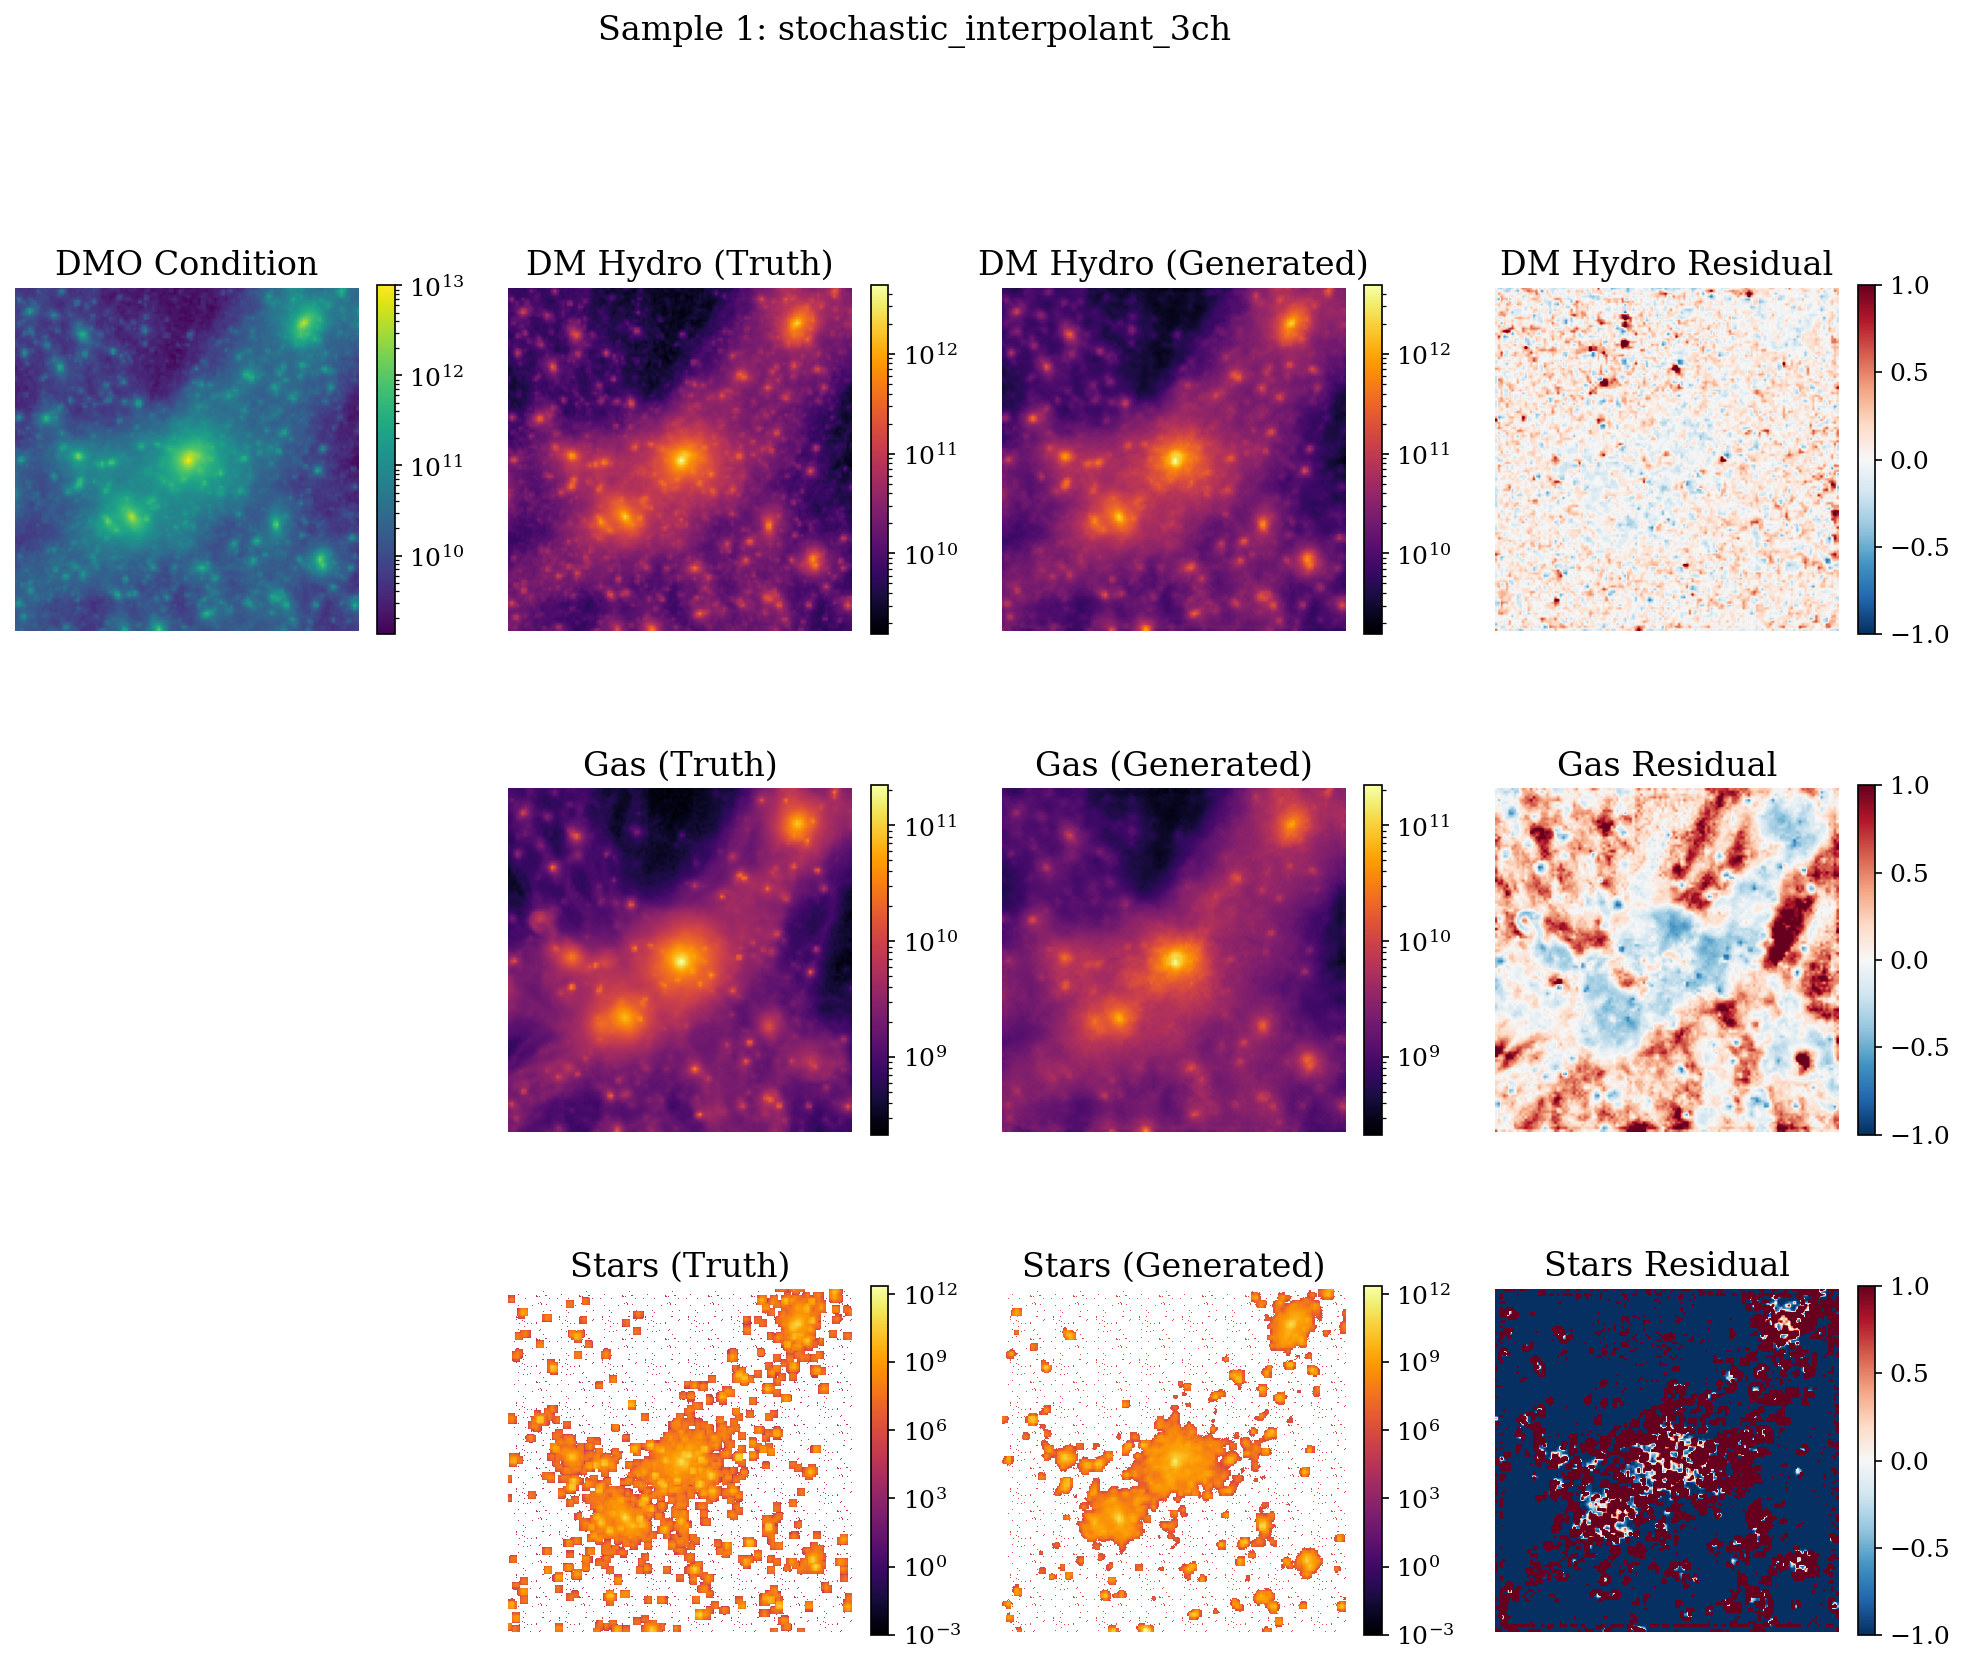


✓ Plotted 1 samples


In [25]:
channel_names = ['DM Hydro', 'Gas', 'Stars']

# Only iterate over actual samples we have
n_samples_to_plot = min(3, len(selected_conditions))

for sample_idx in range(n_samples_to_plot):
    fig = plt.figure(figsize=(16, 12))
    gs = gridspec.GridSpec(3, 4, figure=fig, hspace=0.3, wspace=0.3)
    
    # Get data for this sample
    condition = selected_conditions[sample_idx].numpy()
    target = selected_targets[sample_idx].numpy()
    gen_mean = generated[sample_idx].mean(dim=0).numpy()  # Mean over realizations
    gen_std = generated[sample_idx].std(dim=0).numpy()    # Std over realizations
    
    for ch_idx, ch_name in enumerate(channel_names):
        # Unnormalize
        target_unnorm = unnormalize_field(target[ch_idx], ch_idx, norm_stats, quantile_transformer)
        gen_unnorm = unnormalize_field(gen_mean[ch_idx], ch_idx, norm_stats, quantile_transformer)
        
        # Determine color scale
        vmin = max(1e-3, min(target_unnorm.min(), gen_unnorm.min()))
        vmax = max(target_unnorm.max(), gen_unnorm.max())
        norm = LogNorm(vmin=vmin, vmax=vmax)
        
        # Column 1: Condition (only show once, or DM channel)
        if ch_idx == 0:
            ax = fig.add_subplot(gs[ch_idx, 0])
            cond_unnorm = unnormalize_condition(condition[0], norm_stats)
            im = ax.imshow(cond_unnorm, cmap='viridis', norm=LogNorm())
            ax.set_title('DMO Condition')
            ax.axis('off')
            plt.colorbar(im, ax=ax, fraction=0.046)
        else:
            ax = fig.add_subplot(gs[ch_idx, 0])
            ax.axis('off')
        
        # Column 2: Ground Truth
        ax = fig.add_subplot(gs[ch_idx, 1])
        im = ax.imshow(target_unnorm, cmap='inferno', norm=norm)
        ax.set_title(f'{ch_name} (Truth)')
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046)
        
        # Column 3: Generated (mean)
        ax = fig.add_subplot(gs[ch_idx, 2])
        im = ax.imshow(gen_unnorm, cmap='inferno', norm=norm)
        ax.set_title(f'{ch_name} (Generated)')
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046)
        
        # Column 4: Residual
        ax = fig.add_subplot(gs[ch_idx, 3])
        residual = (gen_unnorm - target_unnorm) / (target_unnorm + 1e-10)
        im = ax.imshow(residual, cmap='RdBu_r', vmin=-1, vmax=1)
        ax.set_title(f'{ch_name} Residual')
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046)
    
    plt.suptitle(f'Sample {sample_idx + 1}: {config.model_name}', fontsize=16, y=1.02)
    
    # Save figure
    fig.savefig(str(FIGURE_DIR / f'{config.model_name}_sample_{sample_idx}_comparison.png'))
    plt.show()

print(f"\n✓ Plotted {n_samples_to_plot} samples")

## Radial Density Profiles

Compute azimuthally-averaged density profiles around halo centers.

In [26]:
2556*4 * 32

327168

In [27]:
def compute_radial_profile(image, center=None, n_bins=50, r_max=None):
    """
    Compute azimuthally-averaged radial profile.
    
    Args:
        image: 2D array
        center: (y, x) center coordinates. If None, use image center.
        n_bins: Number of radial bins
        r_max: Maximum radius. If None, use half the image size.
    
    Returns:
        r_bins: Radial bin centers
        profile: Mean value in each radial bin
        profile_std: Standard deviation in each radial bin
    """
    ny, nx = image.shape
    
    if center is None:
        center = (ny // 2, nx // 2)
    
    if r_max is None:
        r_max = min(ny, nx) // 2
    
    # Create coordinate grids
    y, x = np.ogrid[:ny, :nx]
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    
    # Create radial bins
    r_bins = np.linspace(0, r_max, n_bins + 1)
    r_centers = 0.5 * (r_bins[:-1] + r_bins[1:])
    
    # Compute profile
    profile = np.zeros(n_bins)
    profile_std = np.zeros(n_bins)
    
    for i in range(n_bins):
        mask = (r >= r_bins[i]) & (r < r_bins[i+1])
        if mask.sum() > 0:
            profile[i] = np.mean(image[mask])
            profile_std[i] = np.std(image[mask])
    
    return r_centers, profile, profile_std

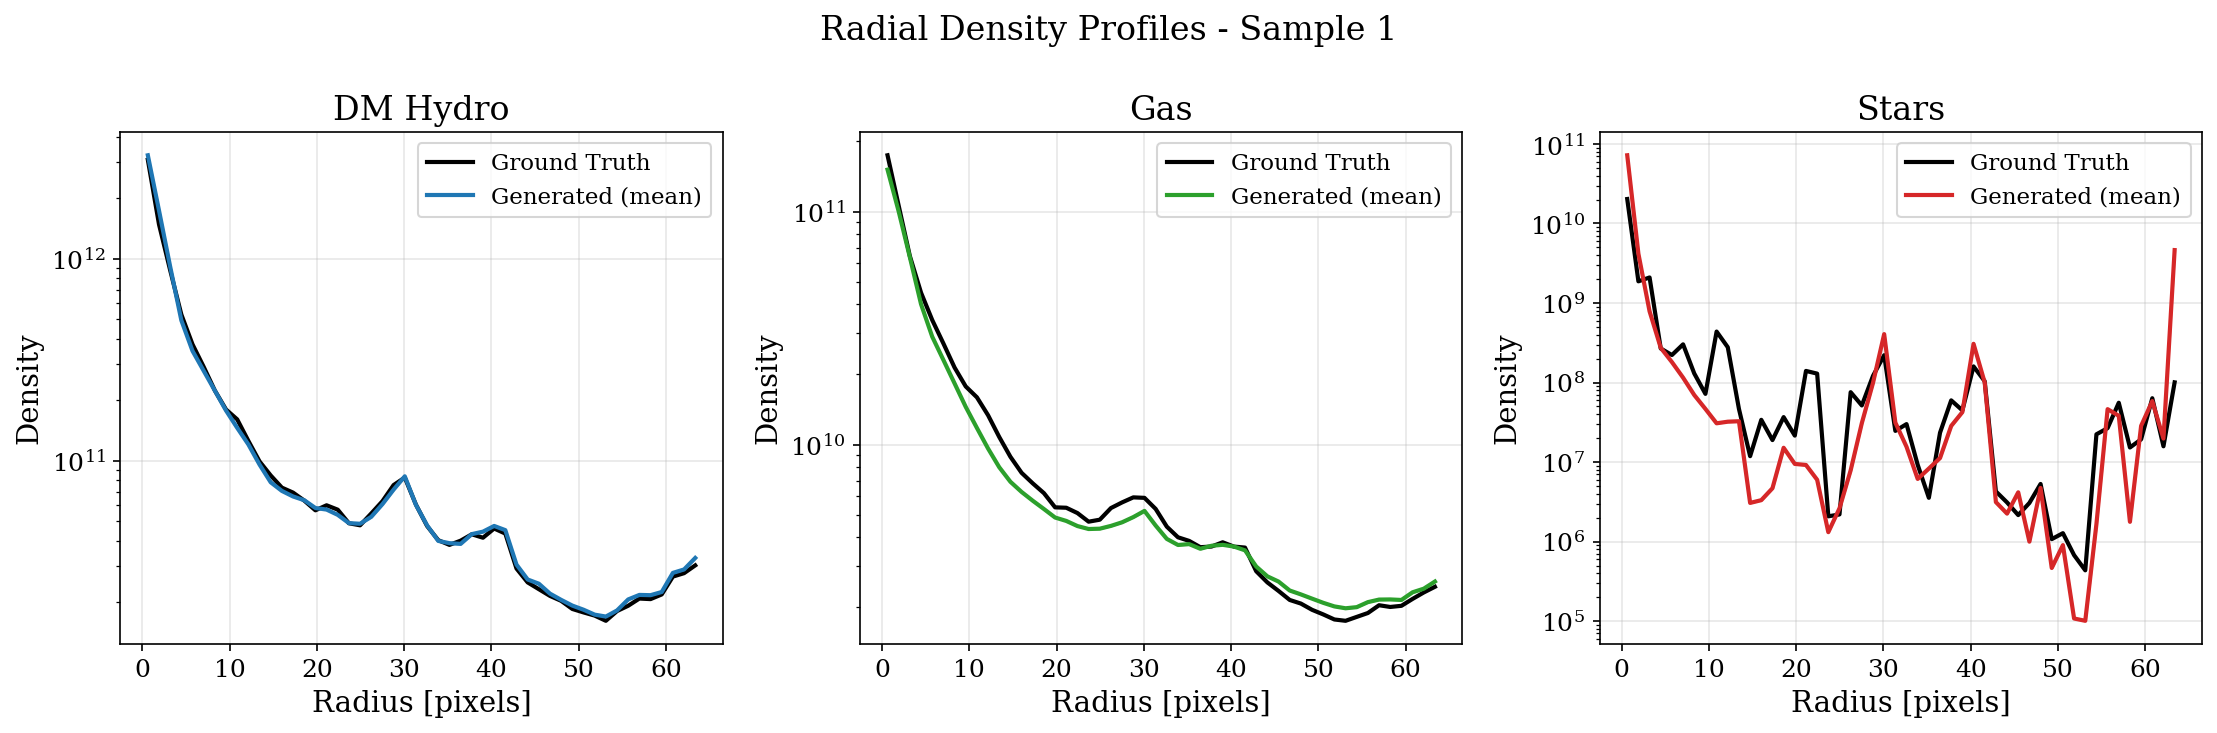

In [28]:
# Compute and plot radial profiles for each sample
channel_colors = ['#1f77b4', '#2ca02c', '#d62728']  # Blue, Green, Red

for sample_idx in range(min(1, N_SAMPLES)):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    target = selected_targets[sample_idx].numpy()
    gen_samples = generated[sample_idx].numpy()  # (N_REALIZATIONS, 3, H, W)
    
    for ch_idx, (ax, ch_name) in enumerate(zip(axes, channel_names)):
        # Unnormalize
        target_unnorm = unnormalize_field(target[ch_idx], ch_idx, norm_stats, quantile_transformer)
        
        # Ground truth profile
        r, profile_true, _ = compute_radial_profile(target_unnorm)
        ax.plot(r, profile_true, 'k-', linewidth=2, label='Ground Truth')
        
        # Generated profiles (multiple realizations)
        gen_profiles = []
        for real_idx in range(N_REALIZATIONS):
            gen_unnorm = unnormalize_field(gen_samples[real_idx, ch_idx], ch_idx, norm_stats, quantile_transformer)
            r, profile_gen, _ = compute_radial_profile(gen_unnorm)
            gen_profiles.append(profile_gen)
            ax.plot(r, profile_gen, '-', color=channel_colors[ch_idx], 
                   alpha=0.3, linewidth=1)
        
        # Mean generated profile
        gen_profiles = np.array(gen_profiles)
        gen_mean = gen_profiles.mean(axis=0)
        gen_std = gen_profiles.std(axis=0)
        
        ax.plot(r, gen_mean, '-', color=channel_colors[ch_idx], 
               linewidth=2, label='Generated (mean)')
        ax.fill_between(r, gen_mean - gen_std, gen_mean + gen_std, 
                       color=channel_colors[ch_idx], alpha=0.2)
        
        ax.set_xlabel('Radius [pixels]')
        ax.set_ylabel('Density')
        ax.set_title(ch_name)
        ax.set_yscale('log')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'Radial Density Profiles - Sample {sample_idx + 1}', fontsize=16)
    plt.tight_layout()
    
    fig.savefig(str(FIGURE_DIR / f'{config.model_name}_sample_{sample_idx}_profiles.png'))
    plt.show()

## Profile Residuals Analysis

In [29]:
# Aggregate profiles across all samples
all_residuals = {ch: [] for ch in channel_names}

for sample_idx in range(min(1, N_SAMPLES)):
    target = selected_targets[sample_idx].numpy()
    gen_mean = generated[sample_idx].mean(dim=0).numpy()
    
    for ch_idx, ch_name in enumerate(channel_names):
        target_unnorm = unnormalize_field(target[ch_idx], ch_idx, norm_stats, quantile_transformer)
        gen_unnorm = unnormalize_field(gen_mean[ch_idx], ch_idx, norm_stats, quantile_transformer)
        
        r, profile_true, _ = compute_radial_profile(target_unnorm)
        _, profile_gen, _ = compute_radial_profile(gen_unnorm)
        
        residual = (profile_gen - profile_true) / (profile_true + 1e-10)
        all_residuals[ch_name].append(residual)

# Convert to arrays
for ch_name in channel_names:
    all_residuals[ch_name] = np.array(all_residuals[ch_name])

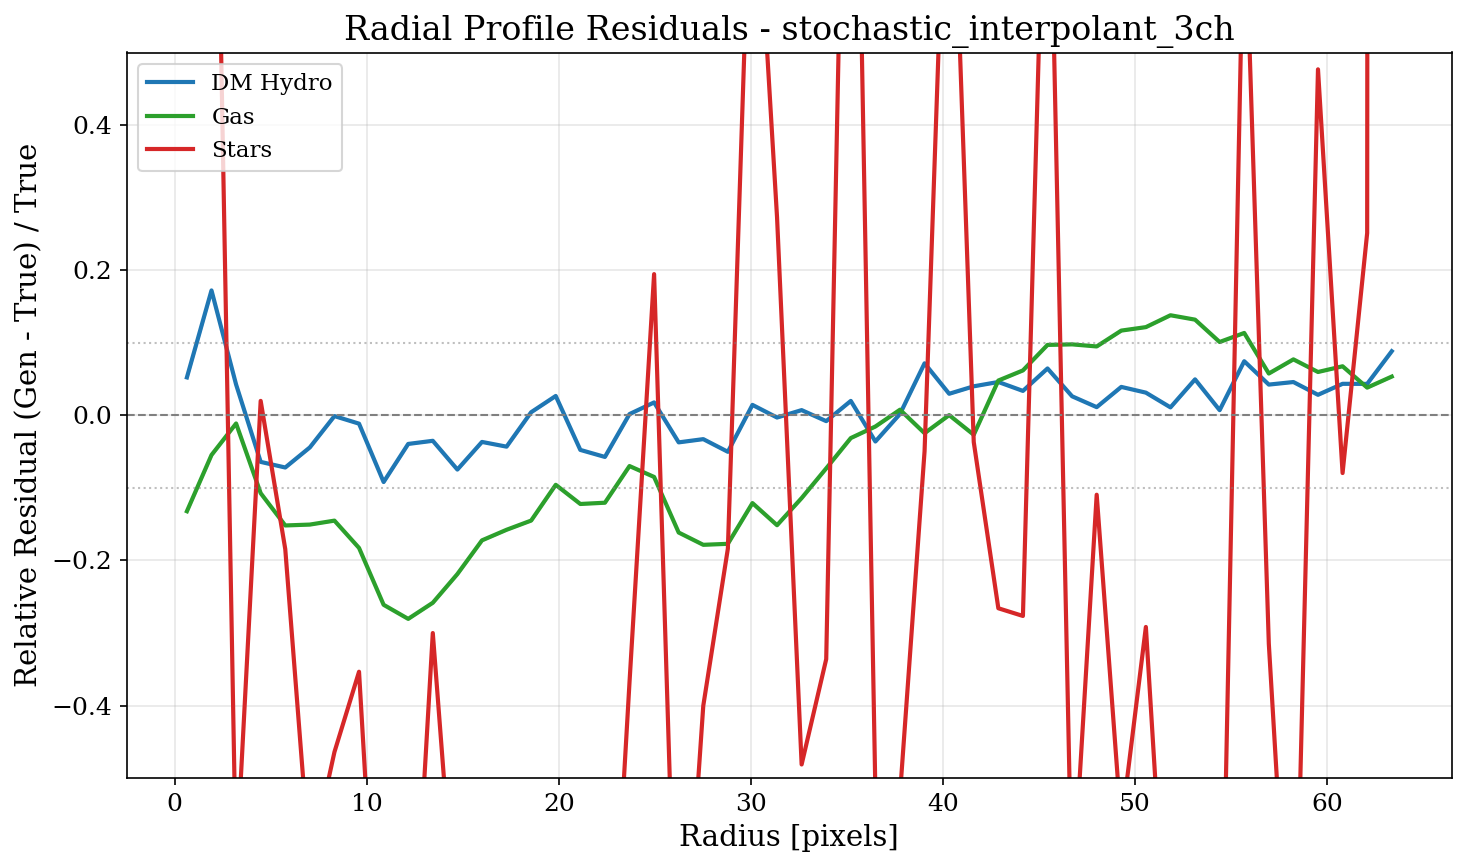

In [30]:
# Plot aggregated residuals
fig, ax = plt.subplots(figsize=(10, 6))

for ch_idx, (ch_name, color) in enumerate(zip(channel_names, channel_colors)):
    residuals = all_residuals[ch_name]
    mean_res = residuals.mean(axis=0)
    std_res = residuals.std(axis=0)
    
    ax.plot(r, mean_res, '-', color=color, linewidth=2, label=ch_name)
    ax.fill_between(r, mean_res - std_res, mean_res + std_res, 
                   color=color, alpha=0.2)

ax.axhline(y=0, color='gray', linestyle='--', linewidth=1)
ax.axhline(y=0.1, color='gray', linestyle=':', linewidth=1, alpha=0.5)
ax.axhline(y=-0.1, color='gray', linestyle=':', linewidth=1, alpha=0.5)

ax.set_xlabel('Radius [pixels]')
ax.set_ylabel('Relative Residual (Gen - True) / True')
ax.set_title(f'Radial Profile Residuals - {config.model_name}')
ax.set_ylim(-0.5, 0.5)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(str(FIGURE_DIR / f'{config.model_name}_profile_residuals.png'))
plt.show()

## Summary Statistics

In [31]:
print(f"\n{'='*60}")
print(f"Validation Summary: {config.model_name}")
print(f"{'='*60}\n")

print(f"Model type: {detected_type}")
print(f"Test samples evaluated: {N_SAMPLES}")
print(f"Realizations per sample: {N_REALIZATIONS}")
if detected_type in ['ddpm', 'interpolant']:
    print(f"Sampling steps: {SAMPLING_STEPS}")
print()

print("Mean Absolute Relative Error (by channel):")
for ch_name in channel_names:
    residuals = all_residuals[ch_name]
    mare = np.abs(residuals).mean()
    print(f"  {ch_name}: {mare:.4f} ({mare*100:.2f}%)")

print("\nBias (by channel):")
for ch_name in channel_names:
    residuals = all_residuals[ch_name]
    bias = residuals.mean()
    print(f"  {ch_name}: {bias:+.4f} ({bias*100:+.2f}%)")


Validation Summary: stochastic_interpolant_3ch

Model type: interpolant
Test samples evaluated: 5
Realizations per sample: 4
Sampling steps: 50

Mean Absolute Relative Error (by channel):
  DM Hydro: 0.0395 (3.95%)
  Gas: 0.1096 (10.96%)
  Stars: 1.4869 (148.69%)

Bias (by channel):
  DM Hydro: +0.0080 (+0.80%)
  Gas: -0.0503 (-5.03%)
  Stars: +0.7037 (+70.37%)


## Compare Multiple Models (Optional)

In [ ]:
# ============================================================================
# MODEL COMPARISON - Set to True to enable
# ============================================================================

COMPARE_MODELS = True

# Sampling steps for different model types
SAMPLING_STEPS_CONFIG = {
    'clean': 1000,       # VDM uses ~250-1000 steps
    'triple': 1000,      # VDM triple uses ~250-1000 steps  
    'ddpm': 1000,        # DDPM uses 250-1000 steps
    'dsm': 250,          # DSM uses ~250 steps (same as DDPM)
    'interpolant': 100,  # Deterministic interpolant ~50-100 steps
    'stochastic_interpolant': 50,  # Stochastic interpolant ~50 steps
    'consistency': 1,    # Consistency models can use 1-4 steps!
    'ot_flow': 50,       # OT Flow uses ~50 steps
}

if COMPARE_MODELS:
    # List of configs to compare: (config_file, label, model_type)
    # All 8 model types are now supported!
    CONFIGS_TO_COMPARE = [
        ('clean_vdm_aggressive_stellar.ini', 'VDM Clean', 'clean'),
        ('clean_vdm_triple.ini', 'VDM Triple', 'triple'),
        ('ddpm.ini', 'DDPM NCSNpp', 'ddpm'),
        ('dsm.ini', 'DSM', 'dsm'),
        ('interpolant.ini', 'Interpolant', 'interpolant'),
        ('stochastic_interpolant.ini', 'Stoch. Interpolant', 'stochastic_interpolant'),
        ('consistency.ini', 'Consistency', 'consistency'),
        ('ot_flow.ini', 'OT Flow', 'ot_flow'),
    ]
    
    comparison_results = {}
    
    for config_file, label, mtype in CONFIGS_TO_COMPARE:
        config_path = PROJECT_ROOT / 'configs' / config_file
        if not config_path.exists():
            print(f"Config not found: {config_path}")
            continue
            
        print(f"\n{'='*60}")
        print(f"Loading {label} ({mtype})...")
        print(f"{'='*60}")
        
        cfg = ConfigLoader(str(config_path), verbose=False)
        
        # Skip if no checkpoint exists
        if cfg.best_ckpt is None:
            print(f"  ⚠️  No checkpoint found, skipping...")
            continue
        
        print(f"  Checkpoint: {cfg.best_ckpt}")
        
        # Resolve quantile path and load quantile transformer for this specific model
        model_quantile_transformer = None
        if hasattr(cfg, 'quantile_path') and cfg.quantile_path is not None:
            qt_path = cfg.quantile_path
            if not os.path.isabs(qt_path):
                qt_path = str(PROJECT_ROOT / qt_path)
            cfg.quantile_path = qt_path
            if os.path.exists(qt_path):
                model_quantile_transformer = joblib.load(qt_path)
                print(f"  ✓ Loaded quantile transformer: {qt_path}")
            else:
                print(f"  ⚠️  Quantile path not found: {qt_path}")
        else:
            print(f"  Using Z-score normalization for stars (no quantile transformer)")
        
        # Load model - ModelManager auto-detects type
        try:
            _, mdl = ModelManager.initialize(cfg, verbose=False, skip_data_loading=True)
            mdl = mdl.to(DEVICE)
            mdl.eval()
        except Exception as e:
            print(f"  ⚠️  Failed to load model: {e}")
            continue
        
        # Set sampling steps based on model type
        sampling_steps = SAMPLING_STEPS_CONFIG.get(mtype, 250)
        if hasattr(mdl, 'n_sampling_steps'):
            mdl.n_sampling_steps = sampling_steps
            if hasattr(mdl, 'hparams'):
                mdl.hparams.n_sampling_steps = sampling_steps
        if mtype == 'consistency' and hasattr(mdl, 'num_steps'):
            mdl.num_steps = sampling_steps
        print(f"  Using {sampling_steps} sampling steps")
        
        # Generate predictions
        print(f"  Generating {N_REALIZATIONS} realizations...")
        import time
        start_time = time.time()
        
        with torch.no_grad():
            gen = sample(mdl, selected_conditions, batch_size=N_REALIZATIONS,
                        conditional_params=selected_params)
        
        gen_time = time.time() - start_time
        print(f"  Generation time: {gen_time:.1f}s ({gen_time/len(selected_conditions):.1f}s per sample)")
        
        # Compute metrics - USE THE MODEL-SPECIFIC quantile_transformer!
        residuals = {ch: [] for ch in channel_names}
        pixel_mse = {ch: [] for ch in channel_names}
        
        for sample_idx in range(min(N_SAMPLES, len(selected_targets))):
            target = selected_targets[sample_idx].numpy()
            gen_mean = gen[sample_idx].mean(dim=0).numpy()
            
            for ch_idx, ch_name in enumerate(channel_names):
                # Use model-specific quantile_transformer for this model
                target_unnorm = unnormalize_field(target[ch_idx], ch_idx, norm_stats, model_quantile_transformer)
                gen_unnorm = unnormalize_field(gen_mean[ch_idx], ch_idx, norm_stats, model_quantile_transformer)
                
                # Radial profile residual
                r, profile_true, _ = compute_radial_profile(target_unnorm)
                _, profile_gen, _ = compute_radial_profile(gen_unnorm)
                residual = (profile_gen - profile_true) / (profile_true + 1e-10)
                residuals[ch_name].append(residual)
                
                # Pixel-wise MSE (in log space)
                log_target = np.log10(target_unnorm + 1)
                log_gen = np.log10(gen_unnorm + 1)
                mse = np.mean((log_target - log_gen)**2)
                pixel_mse[ch_name].append(mse)
        
        comparison_results[label] = {
            'residuals': {ch: np.array(v) for ch, v in residuals.items()},
            'pixel_mse': {ch: np.mean(v) for ch, v in pixel_mse.items()},
            'gen_time': gen_time,
            'model_type': mtype,
            'sampling_steps': sampling_steps,
        }
        print(f"  ✓ Complete")
        
        # Clean up GPU memory
        del mdl
        torch.cuda.empty_cache()
    
    # ==================== RESULTS SUMMARY ====================
    if comparison_results:
        print(f"\n{'='*80}")
        print("MODEL COMPARISON SUMMARY")
        print(f"{'='*80}")
        
        # Print table header
        print(f"\n{'Model':<20} {'Type':<18} {'Steps':<8} {'Time(s)':<10} {'DM MSE':<10} {'Gas MSE':<10} {'Star MSE':<10}")
        print("-" * 96)
        
        for label, results in comparison_results.items():
            mtype = results['model_type']
            steps = results['sampling_steps']
            gen_time = results['gen_time']
            dm_mse = results['pixel_mse']['DM Hydro']
            gas_mse = results['pixel_mse']['Gas']
            star_mse = results['pixel_mse']['Stars']
            print(f"{label:<20} {mtype:<18} {steps:<8} {gen_time:<10.1f} {dm_mse:<10.4f} {gas_mse:<10.4f} {star_mse:<10.4f}")
        
        # ==================== PROFILE RESIDUALS PLOT ====================
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Color scheme for different model types (8 models)
        color_map = {
            'VDM Clean': '#1f77b4',           # Blue
            'VDM Triple': '#2ca02c',          # Green
            'DDPM NCSNpp': '#d62728',         # Red
            'DSM': '#e377c2',                 # Pink
            'Interpolant': '#9467bd',         # Purple
            'Stoch. Interpolant': '#8c564b',  # Brown
            'Consistency': '#ff7f0e',         # Orange
            'OT Flow': '#17becf',             # Cyan
        }
        
        for ch_idx, (ax, ch_name) in enumerate(zip(axes, channel_names)):
            for label, results in comparison_results.items():
                residuals = results['residuals'][ch_name]
                mean_res = residuals.mean(axis=0)
                std_res = residuals.std(axis=0)
                color = color_map.get(label, 'gray')
                
                ax.plot(r, mean_res, '-', linewidth=2, label=label, color=color)
                ax.fill_between(r, mean_res - std_res, mean_res + std_res, 
                               alpha=0.15, color=color)
            
            ax.axhline(y=0, color='gray', linestyle='--', linewidth=1)
            ax.axhline(y=0.1, color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
            ax.axhline(y=-0.1, color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
            ax.set_xlabel('Radius [pixels]')
            ax.set_ylabel('Relative Residual')
            ax.set_title(ch_name)
            ax.set_ylim(-0.5, 0.5)
            ax.legend(fontsize=7, loc='best')
            ax.grid(True, alpha=0.3)
        
        plt.suptitle('Model Comparison: Radial Profile Residuals', fontsize=16)
        plt.tight_layout()
        fig.savefig(str(FIGURE_DIR / 'model_comparison_profiles.png'), dpi=150)
        plt.show()
        
        # ==================== MSE BAR CHART ====================
        fig, ax = plt.subplots(figsize=(14, 6))
        
        models = list(comparison_results.keys())
        x = np.arange(len(models))
        width = 0.25
        
        dm_mse = [comparison_results[m]['pixel_mse']['DM Hydro'] for m in models]
        gas_mse = [comparison_results[m]['pixel_mse']['Gas'] for m in models]
        star_mse = [comparison_results[m]['pixel_mse']['Stars'] for m in models]
        
        ax.bar(x - width, dm_mse, width, label='DM Hydro', color='#1f77b4')
        ax.bar(x, gas_mse, width, label='Gas', color='#2ca02c')
        ax.bar(x + width, star_mse, width, label='Stars', color='#d62728')
        
        ax.set_xlabel('Model')
        ax.set_ylabel('Log-space MSE')
        ax.set_title('Pixel-wise MSE by Model and Channel')
        ax.set_xticks(x)
        ax.set_xticklabels(models, rotation=25, ha='right')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        fig.savefig(str(FIGURE_DIR / 'model_comparison_mse.png'), dpi=150)
        plt.show()
        
        # ==================== GENERATION TIME COMPARISON ====================
        fig, ax = plt.subplots(figsize=(12, 5))
        
        times = [comparison_results[m]['gen_time'] for m in models]
        colors = [color_map.get(m, 'gray') for m in models]
        
        bars = ax.bar(models, times, color=colors)
        ax.set_xlabel('Model')
        ax.set_ylabel('Generation Time (s)')
        ax.set_title(f'Generation Time ({N_SAMPLES} samples, {N_REALIZATIONS} realizations)')
        ax.tick_params(axis='x', rotation=25)
        
        # Add value labels on bars
        for bar, t in zip(bars, times):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                   f'{t:.1f}s', ha='center', va='bottom', fontsize=8)
        
        plt.tight_layout()
        fig.savefig(str(FIGURE_DIR / 'model_comparison_time.png'), dpi=150)
        plt.show()
        
    else:
        print("\n⚠️  No models with checkpoints found for comparison.")


Loading VDM Clean (clean)...
  Checkpoint: /mnt/home/mlee1/ceph/tb_logs/clean_vdm_aggressive_stellar/version_3//checkpoints/epoch=218-step=139941-val/elbo=3.878.ckpt
  ✓ Loaded quantile transformer: /mnt/home/mlee1/vdm_BIND/data/quantile_normalizer_stellar.pkl
  Checkpoint: /mnt/home/mlee1/ceph/tb_logs/clean_vdm_aggressive_stellar/version_3//checkpoints/epoch=218-step=139941-val/elbo=3.878.ckpt
  ✓ Loaded quantile transformer: /mnt/home/mlee1/vdm_BIND/data/quantile_normalizer_stellar.pkl


/mnt/home/mlee1/venvs/torch3/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator QuantileTransformer from version 1.2.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
Seed set to 8


✓ Scale-appropriate Fourier features enabled:
  - Halo (m_dm): High frequencies [1, 2, 4, 8]π -> 8 features per channel
  - Large-scale: Low frequencies [0.25, 0.5, 1, 2]π -> 8 features per channel
  - Target: No Fourier features (learns naturally)
  - Total input channels: 39
✓ Parameter conditioning enabled:
  - Time embedding dim: 384
  - Param embedding dim: 384
  - Total condition dim: 768
✓ Channel progression (encoder): [96, 192, 384, 768, 1024]


In [51]:
# Model Architecture Comparison

This section provides a detailed analysis of the four model architectures used in VDM-BIND:

1. **VDM Clean** - 3-channel Variational Diffusion Model
2. **VDM Triple** - Three independent 1-channel VDMs
3. **DDPM/NCSNpp** - Score-based diffusion (from score_models package)
4. **Interpolant** - Flow matching / stochastic interpolant

SyntaxError: invalid syntax (3866316728.py, line 3)

In [52]:
# ============================================================================
# MODEL ARCHITECTURE ANALYSIS
# ============================================================================

print("="*80)
print("MODEL ARCHITECTURE COMPARISON")
print("="*80)

# ============================================================================
# 1. HIGH-LEVEL OVERVIEW
# ============================================================================
print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                         HIGH-LEVEL MODEL COMPARISON                          ║
╠══════════════════════════════════════════════════════════════════════════════╣
║  Model          │ Network      │ Loss Function       │ Sampling Method       ║
╠═════════════════╪══════════════╪═════════════════════╪═══════════════════════╣
║  VDM Clean      │ UNetVDM      │ ELBO (noise pred)   │ Reverse diffusion     ║
║  VDM Triple     │ 3× UNetVDM   │ 3× ELBO (separate)  │ 3× Reverse diffusion  ║
║  DDPM/NCSNpp    │ NCSNpp       │ DSM (score matching)│ Reverse SDE           ║
║  Interpolant    │ UNetVDM      │ Flow matching (MSE) │ ODE integration       ║
╚══════════════════════════════════════════════════════════════════════════════╝
""")

# ============================================================================
# 2. TRAINING OBJECTIVE COMPARISON
# ============================================================================
print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                           TRAINING OBJECTIVES                                 ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  VDM (Clean & Triple):                                                       ║
║  ───────────────────────                                                     ║
║  • Forward: x_t = α_t·x + σ_t·ε,  where α²+σ²=1 (variance preserving)       ║
║  • Loss: E_t,ε ||ε_θ(x_t, t) - ε||²  (noise prediction)                     ║
║  • Also includes KL divergence and reconstruction terms for full ELBO       ║
║  • Uses learnable noise schedule γ(t) = log(α²/σ²)                          ║
║                                                                              ║
║  DDPM/NCSNpp:                                                                ║
║  ───────────────                                                             ║
║  • Forward: Same diffusion process with VP-SDE or VE-SDE                     ║
║  • Loss: Denoising Score Matching (DSM)                                      ║
║         E_t,x ||s_θ(x_t, t) - ∇_x log p(x_t|x_0)||²                         ║
║  • Score function s(x) = ∇_x log p(x) ≈ -ε/σ                                ║
║  • Equivalent to noise prediction with scaling                               ║
║                                                                              ║
║  Interpolant (Flow Matching):                                                ║
║  ───────────────────────────────                                             ║
║  • Forward: x_t = t·x_1 + (1-t)·x_0  (linear interpolation)                 ║
║  • x_0 = zeros/noise/dm_copy,  x_1 = target hydro                           ║
║  • Loss: E_t ||v_θ(x_t, t) - (x_1 - x_0)||²  (velocity prediction)          ║
║  • Much simpler - no noise schedule, just predict constant velocity!         ║
╚══════════════════════════════════════════════════════════════════════════════╝
""")

# ============================================================================
# 3. NETWORK ARCHITECTURE COMPARISON
# ============================================================================
print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                         NETWORK ARCHITECTURE                                  ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  UNetVDM (VDM Clean, Triple, Interpolant):                                   ║
║  ─────────────────────────────────────────                                   ║
║  • Encoder-Decoder with skip connections                                     ║
║  • ResNet blocks with GroupNorm + SiLU                                       ║
║  • Self-attention at bottleneck                                              ║
║  • FiLM conditioning (Feature-wise Linear Modulation)                        ║
║  • Fourier features for spatial conditioning                                 ║
║  • Optional cross-attention for conditioning                                 ║
║  • Parameter embedding for cosmological params → FiLM modulation             ║
║                                                                              ║
║  NCSNpp (DDPM):                                                              ║
║  ──────────────                                                              ║
║  • Also Encoder-Decoder with skip connections                                ║
║  • Progressive growing architecture                                          ║
║  • BigGAN-style ResNet blocks                                                ║
║  • Attention at multiple resolutions                                         ║
║  • Native "input" conditioning (concatenation)                               ║
║  • No explicit FiLM conditioning                                             ║
║  • Generally larger/deeper than UNetVDM                                      ║
╚══════════════════════════════════════════════════════════════════════════════╝
""")

# ============================================================================
# 4. CONDITIONING MECHANISMS
# ============================================================================
print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                         CONDITIONING MECHANISMS                               ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  SPATIAL CONDITIONING (DMO + Large-scale context):                           ║
║  ─────────────────────────────────────────────────                           ║
║  • VDM: Concatenation OR Cross-attention                                     ║
║    - concat: [x_t, m_dm, large_scale] → conv_in                             ║
║    - cross-attn: Q=features, K/V=conditioning                               ║
║  • NCSNpp: "input" conditioning (concatenation only)                         ║
║    - [x_t, m_dm, large_scale] → network input                               ║
║  • Interpolant: Same as VDM (uses UNetVDM)                                   ║
║                                                                              ║
║  PARAMETER CONDITIONING (Cosmological parameters):                           ║
║  ─────────────────────────────────────────────────                           ║
║  • VDM: FiLM layers modulate features                                        ║
║    - params → MLP → (γ, β) → γ·features + β                                 ║
║    - Each ResNet block receives FiLM modulation                              ║
║  • NCSNpp: "vector" conditioning or embedding addition                       ║
║  • Interpolant: Same as VDM (uses UNetVDM with FiLM)                         ║
║                                                                              ║
║  TIME CONDITIONING:                                                          ║
║  ──────────────────                                                          ║
║  • VDM: Sinusoidal embedding → MLP → combined with param embed               ║
║  • NCSNpp: Fourier time embedding → add to each block                        ║
║  • Interpolant: Same as VDM (time in [0,1])                                  ║
╚══════════════════════════════════════════════════════════════════════════════╝
""")

# ============================================================================
# 5. KEY DIFFERENCES TABLE
# ============================================================================
print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                              KEY DIFFERENCES                                  ║
╠══════════════════════════════════════════════════════════════════════════════╣
║  Aspect              │ VDM           │ DDPM          │ Interpolant           ║
╠══════════════════════╪═══════════════╪═══════════════╪═══════════════════════╣
║  What network        │ Noise ε       │ Score ∇log p  │ Velocity v            ║
║  predicts            │               │ (≈ -ε/σ)      │ (= x_1 - x_0)         ║
╠══════════════════════╪═══════════════╪═══════════════╪═══════════════════════╣
║  Noise schedule      │ Learned γ(t)  │ Fixed β(t)    │ None!                 ║
║                      │ (neural net)  │ (VP/VE SDE)   │                       ║
╠══════════════════════╪═══════════════╪═══════════════╪═══════════════════════╣
║  Sampling process    │ Stochastic    │ Stochastic    │ Deterministic         ║
║                      │ (add noise)   │ (SDE solver)  │ (ODE integration)     ║
╠══════════════════════╪═══════════════╪═══════════════╪═══════════════════════╣
║  Typical steps       │ 250-1000      │ 250-1000      │ 20-50                 ║
╠══════════════════════╪═══════════════╪═══════════════╪═══════════════════════╣
║  Loss complexity     │ ELBO (3 terms)│ DSM (1 term)  │ MSE (1 term)          ║
╠══════════════════════╪═══════════════╪═══════════════╪═══════════════════════╣
║  Hyperparameters     │ γ_min, γ_max  │ β_min, β_max  │ x0_mode, σ            ║
║                      │ (noise sched) │ (SDE params)  │ (initialization)      ║
╠══════════════════════╪═══════════════╪═══════════════╪═══════════════════════╣
║  Stochasticity       │ Inherent      │ Inherent      │ Optional (σ > 0)      ║
║  in samples          │               │               │                       ║
╚══════════════════════════════════════════════════════════════════════════════╝
""")

# ============================================================================
# 6. TRIPLE VDM SPECIAL CONSIDERATIONS
# ============================================================================
print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                    TRIPLE VDM: SPECIAL CONSIDERATIONS                         ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  VDM Triple trains THREE INDEPENDENT single-channel models:                  ║
║                                                                              ║
║    ┌─────────────┐   ┌─────────────┐   ┌─────────────┐                      ║
║    │ DM Model    │   │ Gas Model   │   │ Star Model  │                      ║
║    │ (1-ch out)  │   │ (1-ch out)  │   │ (1-ch out)  │                      ║
║    └──────┬──────┘   └──────┬──────┘   └──────┬──────┘                      ║
║           │                 │                 │                              ║
║           ↓                 ↓                 ↓                              ║
║    loss_dm → backward   loss_gas → backward   loss_star → backward          ║
║    (separate optimizer per model)                                            ║
║                                                                              ║
║  Key properties:                                                             ║
║  • NO gradient sharing between channels                                      ║
║  • Each model has its own noise schedule                                     ║
║  • Can specialize for different channel characteristics                      ║
║  • More interpretable - each model is independent                            ║
║  • 3× memory for weights but parallelizable                                  ║
║                                                                              ║
║  vs VDM Clean (joint 3-channel):                                             ║
║  • Single model learns all channels together                                 ║
║  • Potential for cross-channel information sharing                           ║
║  • Single noise schedule for all channels                                    ║
║  • Channel weights balance the loss                                          ║
╚══════════════════════════════════════════════════════════════════════════════╝
""")

# ============================================================================
# 7. FOURIER FEATURES COMPARISON
# ============================================================================
print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                          FOURIER FEATURES                                     ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  UNetVDM supports two Fourier feature modes:                                 ║
║                                                                              ║
║  Legacy Mode (backward compatible):                                          ║
║  • Frequencies: 2^(-2:1) × 2π = [0.25π, 0.5π, π, 2π]                        ║
║  • Applied to FIRST channel only of concatenated input                       ║
║  • Output: 8 features (4 freq × 2 for sin/cos)                              ║
║                                                                              ║
║  New Mode (scale-appropriate):                                               ║
║  • Halo (m_dm): High frequencies [1, 2, 4, 8]π                              ║
║    → Captures small-scale structure (24-195 kpc at 6.25 Mpc)                ║
║  • Large-scale: Low frequencies [0.25, 0.5, 1, 2]π                          ║
║    → Captures environmental modulation (49-391 kpc at 12.5 Mpc)             ║
║  • Applied separately to each conditioning type                              ║
║                                                                              ║
║  NCSNpp:                                                                     ║
║  • No explicit Fourier features on spatial input                             ║
║  • Uses sinusoidal embeddings for time only                                  ║
║  • Relies on network depth for multi-scale learning                          ║
╚══════════════════════════════════════════════════════════════════════════════╝
""")

print("\n✓ Architecture analysis complete")
print("="*80)

MODEL ARCHITECTURE COMPARISON

╔══════════════════════════════════════════════════════════════════════════════╗
║                         HIGH-LEVEL MODEL COMPARISON                          ║
╠══════════════════════════════════════════════════════════════════════════════╣
║  Model          │ Network      │ Loss Function       │ Sampling Method       ║
╠═════════════════╪══════════════╪═════════════════════╪═══════════════════════╣
║  VDM Clean      │ UNetVDM      │ ELBO (noise pred)   │ Reverse diffusion     ║
║  VDM Triple     │ 3× UNetVDM   │ 3× ELBO (separate)  │ 3× Reverse diffusion  ║
║  DDPM/NCSNpp    │ NCSNpp       │ DSM (score matching)│ Reverse SDE           ║
║  Interpolant    │ UNetVDM      │ Flow matching (MSE) │ ODE integration       ║
╚══════════════════════════════════════════════════════════════════════════════╝


╔══════════════════════════════════════════════════════════════════════════════╗
║                           TRAINING OBJECTIVES                             

In [53]:
# ============================================================================
# MODEL PARAMETER COUNTS
# ============================================================================

print("\n" + "="*80)
print("MODEL PARAMETER COUNTS")
print("="*80)

def count_parameters(model):
    """Count trainable and total parameters."""
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

def format_params(n):
    """Format parameter count in human-readable form."""
    if n >= 1e9:
        return f"{n/1e9:.2f}B"
    elif n >= 1e6:
        return f"{n/1e6:.2f}M"
    elif n >= 1e3:
        return f"{n/1e3:.2f}K"
    return str(n)

# Dictionary to store model info
model_info = {}

# Try to load each model type and count parameters
MODEL_CONFIGS = {
    'clean': ('clean_vdm_aggressive_stellar.ini', 'VDM Clean'),
    'triple': ('clean_vdm_triple.ini', 'VDM Triple'),
    'ddpm': ('ddpm.ini', 'DDPM NCSNpp'),
    'interpolant': ('interpolant.ini', 'Interpolant'),
}

for mtype, (config_file, label) in MODEL_CONFIGS.items():
    config_path = PROJECT_ROOT / 'configs' / config_file
    if not config_path.exists():
        print(f"⚠️  Config not found: {config_file}")
        continue
    
    try:
        cfg = ConfigLoader(str(config_path), verbose=False)
        if cfg.best_ckpt is None:
            print(f"⚠️  {label}: No checkpoint found")
            continue
            
        # Resolve quantile path
        if hasattr(cfg, 'quantile_path') and cfg.quantile_path is not None:
            if not os.path.isabs(cfg.quantile_path):
                cfg.quantile_path = str(PROJECT_ROOT / cfg.quantile_path)
        
        # Load model
        _, mdl = ModelManager.initialize(cfg, verbose=False, skip_data_loading=True)
        
        # Count parameters
        total, trainable = count_parameters(mdl)
        
        # Get architecture details
        if hasattr(mdl, 'model'):
            # VDM and Interpolant wrap the network
            net = mdl.model
            if hasattr(net, 'score_model'):
                net = net.score_model  # For VDM
        else:
            net = mdl
        
        # Get embedding dim
        embed_dim = getattr(net, 'embedding_dim', getattr(cfg, 'embedding_dim', 'N/A'))
        n_blocks = getattr(net, 'n_blocks', getattr(cfg, 'n_blocks', 'N/A'))
        
        model_info[label] = {
            'total_params': total,
            'trainable_params': trainable,
            'embed_dim': embed_dim,
            'n_blocks': n_blocks,
            'type': mtype,
        }
        
        del mdl
        torch.cuda.empty_cache()
        
    except Exception as e:
        print(f"⚠️  {label}: Error loading - {str(e)[:50]}")

# Print comparison table
print(f"\n{'Model':<20} {'Total Params':<15} {'Trainable':<15} {'Embed Dim':<12} {'Blocks':<8}")
print("-" * 75)

for label, info in model_info.items():
    total_str = format_params(info['total_params'])
    train_str = format_params(info['trainable_params'])
    embed = info['embed_dim']
    blocks = info['n_blocks']
    print(f"{label:<20} {total_str:<15} {train_str:<15} {str(embed):<12} {str(blocks):<8}")

# Note about Triple VDM``
if 'VDM Triple' in model_info:
    triple_params = model_info['VDM Triple']['total_params']
    print(f"\n📝 Note: VDM Triple has 3 independent models, each ~{format_params(triple_params//3)}")
    print(f"   Total params = 3 × single model params")

print("\n" + "="*80)


MODEL PARAMETER COUNTS


Seed set to 8


✓ Scale-appropriate Fourier features enabled:
  - Halo (m_dm): High frequencies [1, 2, 4, 8]π -> 8 features per channel
  - Large-scale: Low frequencies [0.25, 0.5, 1, 2]π -> 8 features per channel
  - Target: No Fourier features (learns naturally)
  - Total input channels: 39
✓ Parameter conditioning enabled:
  - Time embedding dim: 384
  - Param embedding dim: 384
  - Total condition dim: 768
✓ Channel progression (encoder): [96, 192, 384, 768, 1024]
✓ Final decoder channels: 64 (GroupNorm groups: 8)
✓ Parameter predictor added (predicts 35 params)

INITIALIZING CLEAN VDM MODEL

📊 MODEL CONFIGURATION:
  Image shape: (3, 128, 128)
  Noise schedule: learned_nn
  Gamma range: [-13.3, 13.0]
  Data noise (per-channel): (0.0005, 0.0005, 0.0005)
  Loss weights (diffusion, latent, recons): 1.0, 1.0, 1.0

🎯 CHANNEL WEIGHTS: (1, 1, 1)

✓ Parameter prediction enabled (weight=0.01)




Seed set to 42


✓ Scale-appropriate Fourier features enabled:
  - Halo (m_dm): High frequencies [1, 2, 4, 8]π -> 8 features per channel
  - Large-scale: Low frequencies [0.25, 0.5, 1, 2]π -> 8 features per channel
  - Target: No Fourier features (learns naturally)
  - Total input channels: 37
✓ Parameter conditioning enabled:
  - Time embedding dim: 384
  - Param embedding dim: 384
  - Total condition dim: 768
✓ Channel progression (encoder): [96, 192, 384, 768, 1024]
✓ Final decoder channels: 64 (GroupNorm groups: 8)
✓ Parameter predictor added (predicts 35 params)
✓ Scale-appropriate Fourier features enabled:
  - Halo (m_dm): High frequencies [1, 2, 4, 8]π -> 8 features per channel
  - Large-scale: Low frequencies [0.25, 0.5, 1, 2]π -> 8 features per channel
  - Target: No Fourier features (learns naturally)
  - Total input channels: 37
✓ Parameter conditioning enabled:
  - Time embedding dim: 384
  - Param embedding dim: 384
  - Total condition dim: 768
✓ Channel progression (encoder): [96, 192, 38

Seed set to 8
Seed set to 8


✓ Scale-appropriate Fourier features enabled:
  - Halo (m_dm): High frequencies [1, 2, 4, 8]π -> 8 features per channel
  - Large-scale: Low frequencies [0.25, 0.5, 1, 2]π -> 8 features per channel
  - Target: No Fourier features (learns naturally)
  - Total input channels: 39
✓ Parameter conditioning enabled:
  - Time embedding dim: 1024
  - Param embedding dim: 1024
  - Total condition dim: 2048
✓ Channel progression (encoder): [256, 512, 1024, 1024, 1024]
✓ Final decoder channels: 64 (GroupNorm groups: 8)
✓ Parameter predictor added (predicts 35 params)

INITIALIZED LIGHT INTERPOLANT MODEL
  Learning rate: 0.0001
  Sampling steps: 50
  Stochastic: False (sigma=0.0)
  x0 mode: dm_copy
  Param conditioning: True


Model                Total Params    Trainable       Embed Dim    Blocks  
---------------------------------------------------------------------------
VDM Clean            247.77M         247.77M         96           5       
VDM Triple           743.30M         743.30M     

In [23]:
# ============================================================================
# SAMPLING ALGORITHM COMPARISON
# ============================================================================

print("\n" + "="*80)
print("SAMPLING ALGORITHMS")
print("="*80)

print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                          VDM SAMPLING (ANCESTRAL)                             ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  Algorithm: Ancestral sampling from t=1 to t=0                               ║
║                                                                              ║
║  for t in [1.0, ..., 0.0]:                                                   ║
║      ε_pred = network(x_t, t, conditioning)     # Predict noise              ║
║      x̂_0 = (x_t - σ_t·ε_pred) / α_t            # Estimate clean             ║
║      x_{t-Δt} = α_{t-Δt}·x̂_0 + σ_{t-Δt}·ε_new  # Add appropriate noise      ║
║                                                                              ║
║  Key: Each step adds fresh noise (stochastic)                                ║
║  α_t, σ_t derived from learned γ(t) = log(α²/σ²)                            ║
╚══════════════════════════════════════════════════════════════════════════════╝

╔══════════════════════════════════════════════════════════════════════════════╗
║                          DDPM SAMPLING (SDE SOLVER)                           ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  Algorithm: Euler-Maruyama discretization of reverse SDE                     ║
║                                                                              ║
║  dx = [f(x,t) - g(t)²·s(x,t)]dt + g(t)dW̄    # Reverse SDE                   ║
║                                                                              ║
║  for t in [1.0, ..., 0.0]:                                                   ║
║      s_pred = network(x_t, t, conditioning)     # Predict score              ║
║      drift = f(x_t, t) - g(t)²·s_pred                                        ║
║      diffusion = g(t)·z  (where z ~ N(0, I))                                 ║
║      x_{t-Δt} = x_t + drift·Δt + diffusion·√Δt                              ║
║                                                                              ║
║  f(t), g(t) depend on SDE type (VP or VE)                                    ║
╚══════════════════════════════════════════════════════════════════════════════╝

╔══════════════════════════════════════════════════════════════════════════════╗
║                        INTERPOLANT SAMPLING (ODE)                             ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  Algorithm: Euler integration of ODE from t=0 to t=1                         ║
║                                                                              ║
║  dx/dt = v(x, t, conditioning)                  # Velocity field ODE         ║
║                                                                              ║
║  x = x_0  (zeros, noise, or dm_copy)                                         ║
║  for t in [0.0, ..., 1.0]:                                                   ║
║      v_pred = network(x, t, conditioning)       # Predict velocity           ║
║      x = x + v_pred·Δt                          # Euler step                 ║
║                                                                              ║
║  Key features:                                                               ║
║  • DETERMINISTIC (no noise added during sampling)                            ║
║  • Integrates FORWARD in time (0→1), not backward (1→0)                      ║
║  • Much simpler - just follow the velocity field                             ║
║  • Can use better ODE solvers (RK4, Heun) for fewer steps                    ║
╚══════════════════════════════════════════════════════════════════════════════╝
""")

# Sampling speed comparison
print("\n📊 SAMPLING SPEED COMPARISON (approximate):")
print("-" * 60)
print(f"{'Method':<20} {'Steps':<10} {'Relative Speed':<20}")
print("-" * 60)
print(f"{'VDM (ancestral)':<20} {'250-1000':<10} {'1.0× (baseline)':<20}")
print(f"{'DDPM (EM solver)':<20} {'250-1000':<10} {'~1.0×':<20}")
print(f"{'Interpolant (Euler)':<20} {'20-50':<10} {'5-20× faster':<20}")
print(f"{'Interpolant (RK4)':<20} {'10-25':<10} {'10-40× faster':<20}")
print("-" * 60)

print("""
💡 Why is Interpolant faster?

1. SIMPLER OBJECTIVE: Predict velocity v = x_1 - x_0 (constant!)
   vs noise ε or score ∇log p (varies with t)

2. DETERMINISTIC ODE: No stochastic noise to add/remove each step
   - Fewer operations per step
   - Can use adaptive step-size solvers

3. STRAIGHTER PATHS: Linear interpolation → velocity field is nearly constant
   - Euler method is very accurate
   - Fewer steps needed for same quality

4. HIGHER-ORDER SOLVERS: Can use RK4, Heun, etc. for even fewer steps
   - Not possible with stochastic samplers (noise breaks higher-order methods)
""")

print("="*80)


SAMPLING ALGORITHMS

╔══════════════════════════════════════════════════════════════════════════════╗
║                          VDM SAMPLING (ANCESTRAL)                             ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  Algorithm: Ancestral sampling from t=1 to t=0                               ║
║                                                                              ║
║  for t in [1.0, ..., 0.0]:                                                   ║
║      ε_pred = network(x_t, t, conditioning)     # Predict noise              ║
║      x̂_0 = (x_t - σ_t·ε_pred) / α_t            # Estimate clean             ║
║      x_{t-Δt} = α_{t-Δt}·x̂_0 + σ_{t-Δt}·ε_new  # Add appropriate noise      ║
║                                                                              ║
║  Key: Each step adds fresh noise (stochastic)                                ║
║  α_

/tmp/ipykernel_3505943/2668682796.py:179: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3505943/2668682796.py:180: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from current font.
  fig.savefig(str(FIGURE_DIR / 'model_architecture_comparison.png'), dpi=150)
/tmp/ipykernel_3505943/2668682796.py:180: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from current font.
  fig.savefig(str(FIGURE_DIR / 'model_architecture_comparison.png'), dpi=150)
/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)

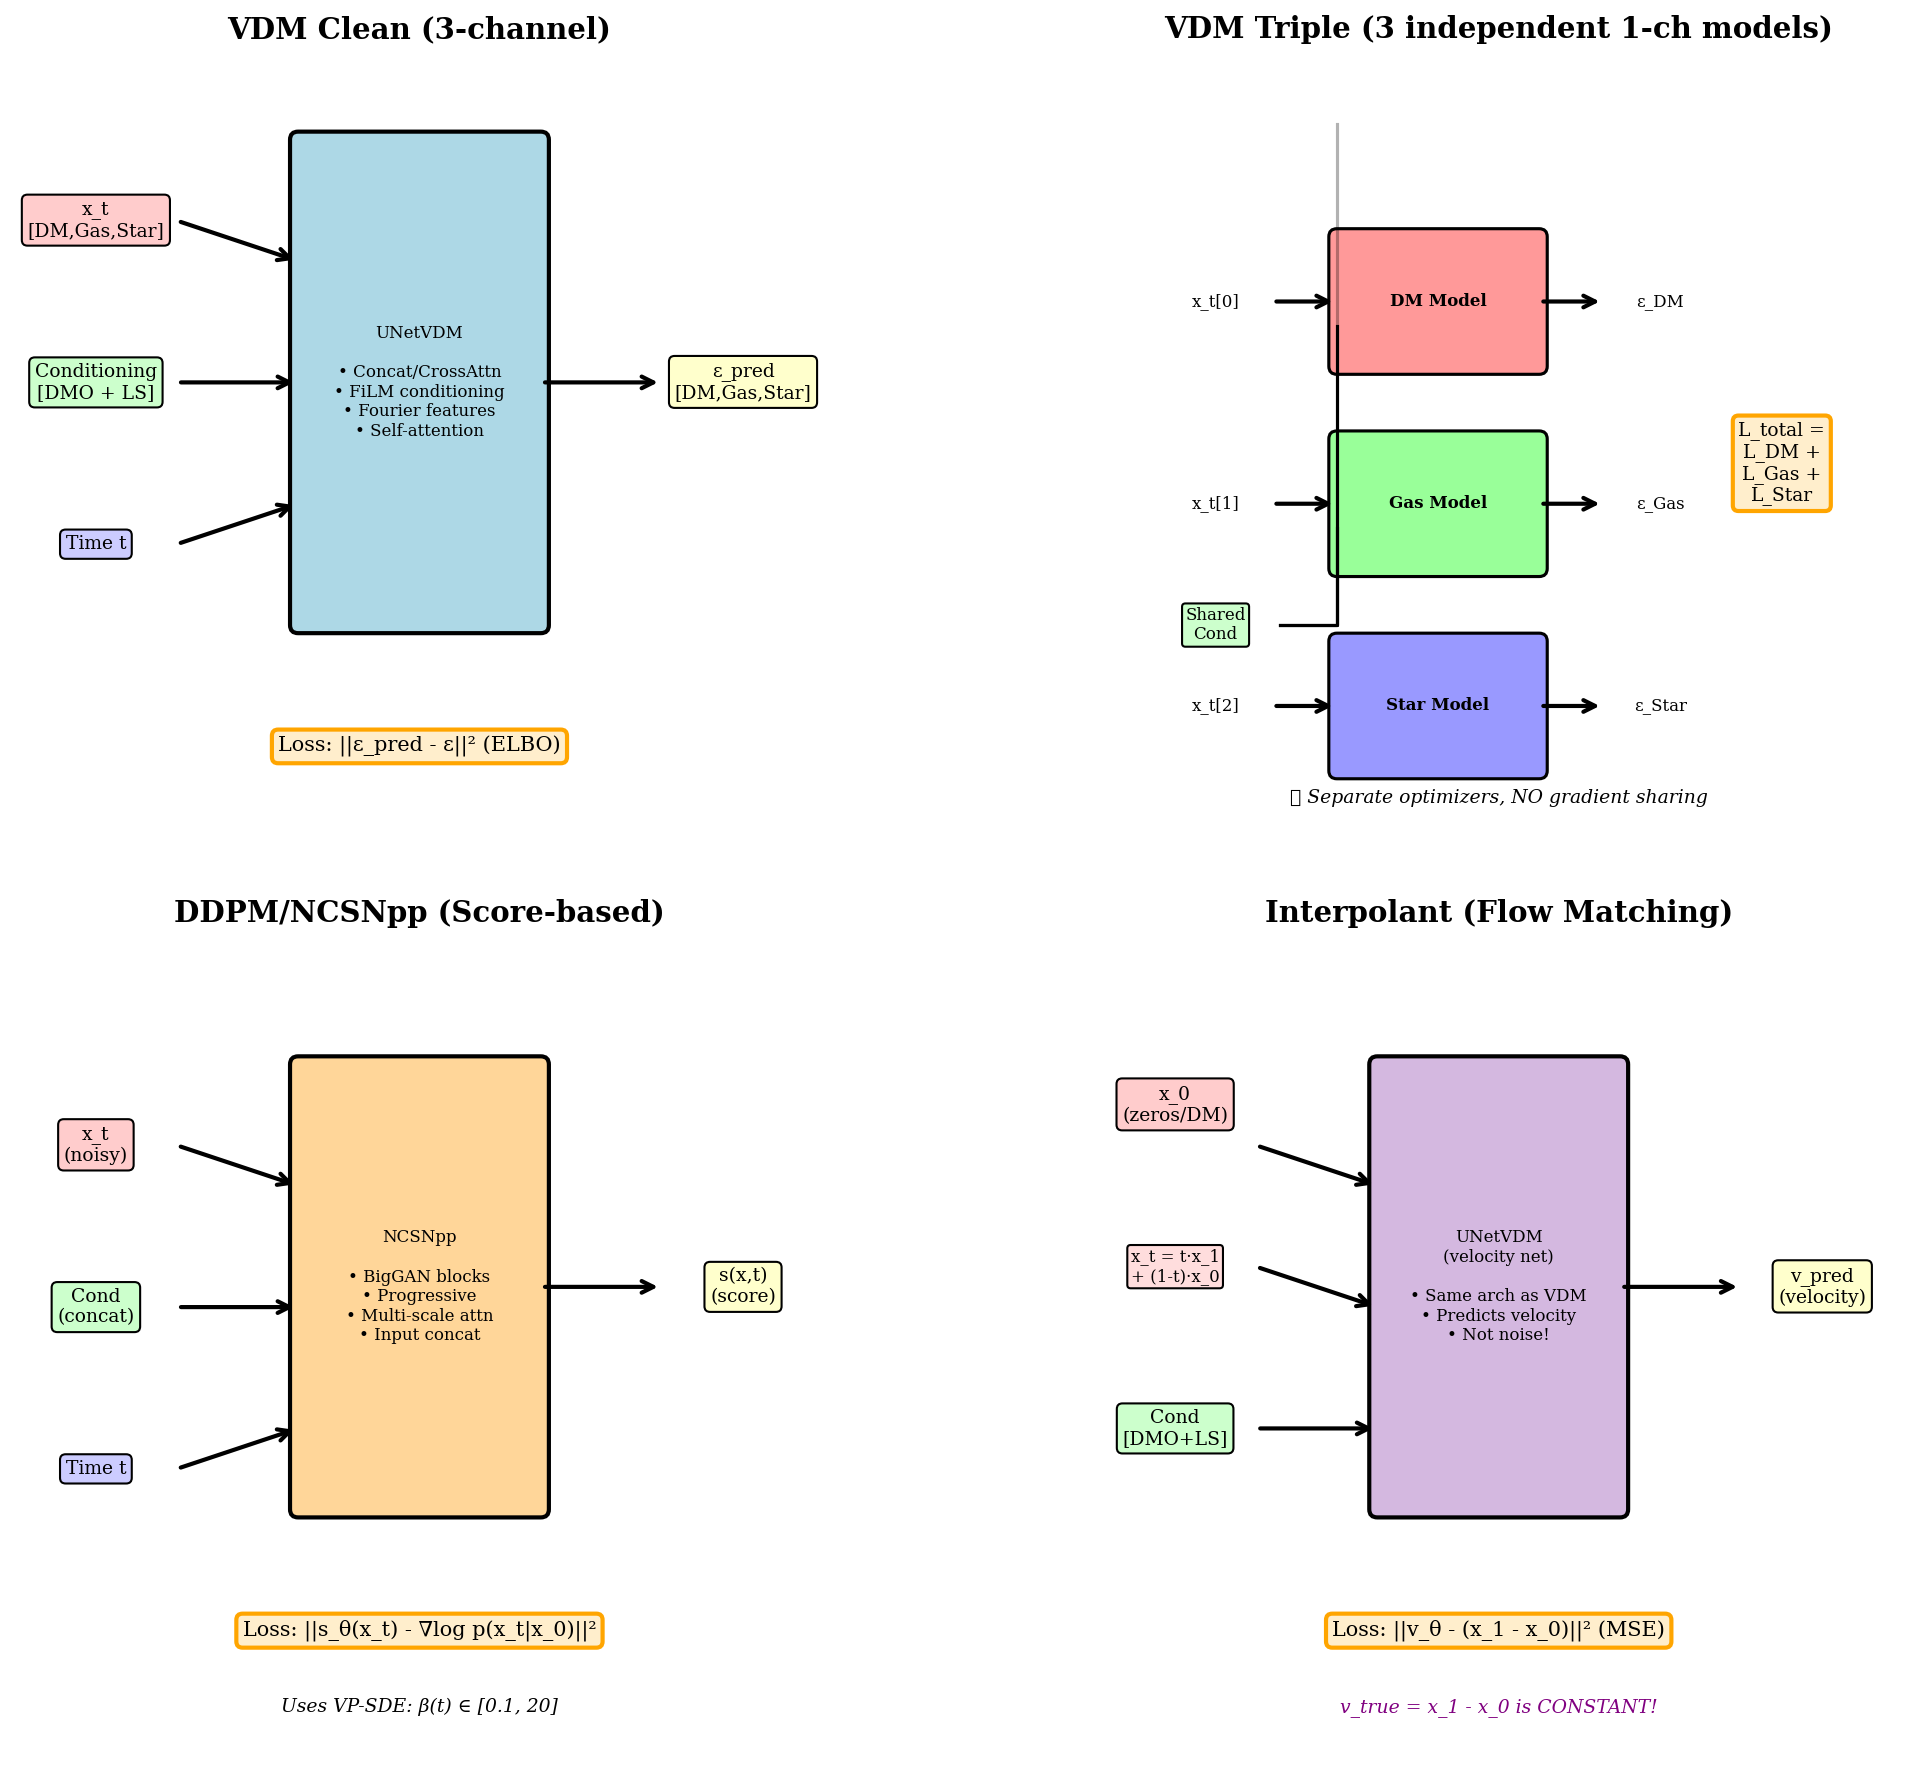


✓ Architecture diagrams saved to figures/training/


In [24]:
# ============================================================================
# VISUAL ARCHITECTURE DIAGRAM
# ============================================================================

import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Common styling
box_style = dict(boxstyle="round,pad=0.3", facecolor='lightblue', edgecolor='black', linewidth=2)
arrow_props = dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='black', lw=2)

# ============================================================================
# Panel 1: VDM Clean (3-channel)
# ============================================================================
ax = axes[0, 0]
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('VDM Clean (3-channel)', fontsize=14, fontweight='bold', pad=10)

# Input
ax.text(1, 8, 'x_t\n[DM,Gas,Star]', ha='center', va='center', fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", facecolor='#ffcccc'))
# Conditioning
ax.text(1, 6, 'Conditioning\n[DMO + LS]', ha='center', va='center', fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", facecolor='#ccffcc'))
# Time
ax.text(1, 4, 'Time t', ha='center', va='center', fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", facecolor='#ccccff'))

# UNet
ax.add_patch(FancyBboxPatch((3.5, 3), 3, 6, boxstyle="round,pad=0.1", 
                            facecolor='lightblue', edgecolor='black', linewidth=2))
ax.text(5, 6, 'UNetVDM\n\n• Concat/CrossAttn\n• FiLM conditioning\n• Fourier features\n• Self-attention', 
        ha='center', va='center', fontsize=8)

# Output
ax.text(9, 6, 'ε_pred\n[DM,Gas,Star]', ha='center', va='center', fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", facecolor='#ffffcc'))

# Arrows
ax.annotate('', xy=(3.5, 7.5), xytext=(2, 8), arrowprops=arrow_props)
ax.annotate('', xy=(3.5, 6), xytext=(2, 6), arrowprops=arrow_props)
ax.annotate('', xy=(3.5, 4.5), xytext=(2, 4), arrowprops=arrow_props)
ax.annotate('', xy=(8, 6), xytext=(6.5, 6), arrowprops=arrow_props)

# Loss
ax.text(5, 1.5, 'Loss: ||ε_pred - ε||² (ELBO)', ha='center', va='center', fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", facecolor='#ffeecc', edgecolor='orange', linewidth=2))

# ============================================================================
# Panel 2: VDM Triple (3 separate models)
# ============================================================================
ax = axes[0, 1]
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('VDM Triple (3 independent 1-ch models)', fontsize=14, fontweight='bold', pad=10)

# Three parallel networks
colors = ['#ff9999', '#99ff99', '#9999ff']
labels = ['DM Model', 'Gas Model', 'Star Model']
outputs = ['ε_DM', 'ε_Gas', 'ε_Star']

for i, (color, label, out) in enumerate(zip(colors, labels, outputs)):
    y_offset = 7 - i * 2.5
    # Network box
    ax.add_patch(FancyBboxPatch((3, y_offset-0.8), 2.5, 1.6, boxstyle="round,pad=0.1",
                                facecolor=color, edgecolor='black', linewidth=1.5))
    ax.text(4.25, y_offset, label, ha='center', va='center', fontsize=8, fontweight='bold')
    # Input
    ax.text(1.5, y_offset, f'x_t[{i}]', ha='center', va='center', fontsize=8)
    # Output
    ax.text(7, y_offset, out, ha='center', va='center', fontsize=8)
    # Arrows
    ax.annotate('', xy=(3, y_offset), xytext=(2.2, y_offset), arrowprops=arrow_props)
    ax.annotate('', xy=(6.3, y_offset), xytext=(5.5, y_offset), arrowprops=arrow_props)

# Conditioning (shared)
ax.text(1.5, 3, 'Shared\nCond', ha='center', va='center', fontsize=8,
        bbox=dict(boxstyle="round,pad=0.2", facecolor='#ccffcc'))
ax.plot([2.3, 3, 3], [3, 3, 4.2], 'k-', lw=1.5)
ax.plot([2.3, 3, 3], [3, 3, 6.7], 'k-', lw=1.5)
ax.plot([2.3, 3, 3], [3, 3, 9.2], 'k-', lw=1.5, alpha=0.3)  # faded for top

# Loss
ax.text(8.5, 5, 'L_total =\nL_DM +\nL_Gas +\nL_Star', ha='center', va='center', fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", facecolor='#ffeecc', edgecolor='orange', linewidth=2))

# Note
ax.text(5, 0.8, '⚠️ Separate optimizers, NO gradient sharing', ha='center', fontsize=9, style='italic')

# ============================================================================
# Panel 3: DDPM/NCSNpp
# ============================================================================
ax = axes[1, 0]
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('DDPM/NCSNpp (Score-based)', fontsize=14, fontweight='bold', pad=10)

# Input
ax.text(1, 7.5, 'x_t\n(noisy)', ha='center', va='center', fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", facecolor='#ffcccc'))
# Conditioning
ax.text(1, 5.5, 'Cond\n(concat)', ha='center', va='center', fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", facecolor='#ccffcc'))
# Time
ax.text(1, 3.5, 'Time t', ha='center', va='center', fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", facecolor='#ccccff'))

# NCSNpp
ax.add_patch(FancyBboxPatch((3.5, 3), 3, 5.5, boxstyle="round,pad=0.1",
                            facecolor='#ffd699', edgecolor='black', linewidth=2))
ax.text(5, 5.75, 'NCSNpp\n\n• BigGAN blocks\n• Progressive\n• Multi-scale attn\n• Input concat', 
        ha='center', va='center', fontsize=8)

# Output
ax.text(9, 5.75, 's(x,t)\n(score)', ha='center', va='center', fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", facecolor='#ffffcc'))

# Arrows
ax.annotate('', xy=(3.5, 7), xytext=(2, 7.5), arrowprops=arrow_props)
ax.annotate('', xy=(3.5, 5.5), xytext=(2, 5.5), arrowprops=arrow_props)
ax.annotate('', xy=(3.5, 4), xytext=(2, 3.5), arrowprops=arrow_props)
ax.annotate('', xy=(8, 5.75), xytext=(6.5, 5.75), arrowprops=arrow_props)

# Loss and note
ax.text(5, 1.5, 'Loss: ||s_θ(x_t) - ∇log p(x_t|x_0)||²', ha='center', va='center', fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", facecolor='#ffeecc', edgecolor='orange', linewidth=2))
ax.text(5, 0.5, 'Uses VP-SDE: β(t) ∈ [0.1, 20]', ha='center', fontsize=9, style='italic')

# ============================================================================
# Panel 4: Interpolant (Flow Matching)
# ============================================================================
ax = axes[1, 1]
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('Interpolant (Flow Matching)', fontsize=14, fontweight='bold', pad=10)

# x_0 (source)
ax.text(1, 8, 'x_0\n(zeros/DM)', ha='center', va='center', fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", facecolor='#ffcccc'))
# x_t (interpolated)
ax.text(1, 6, 'x_t = t·x_1\n+ (1-t)·x_0', ha='center', va='center', fontsize=8,
        bbox=dict(boxstyle="round,pad=0.2", facecolor='#ffdddd'))
# Conditioning
ax.text(1, 4, 'Cond\n[DMO+LS]', ha='center', va='center', fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", facecolor='#ccffcc'))

# UNet
ax.add_patch(FancyBboxPatch((3.5, 3), 3, 5.5, boxstyle="round,pad=0.1",
                            facecolor='#d4b8e0', edgecolor='black', linewidth=2))
ax.text(5, 5.75, 'UNetVDM\n(velocity net)\n\n• Same arch as VDM\n• Predicts velocity\n• Not noise!', 
        ha='center', va='center', fontsize=8)

# Output
ax.text(9, 5.75, 'v_pred\n(velocity)', ha='center', va='center', fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", facecolor='#ffffcc'))

# Arrows
ax.annotate('', xy=(3.5, 7), xytext=(2, 7.5), arrowprops=arrow_props)
ax.annotate('', xy=(3.5, 5.5), xytext=(2, 6), arrowprops=arrow_props)
ax.annotate('', xy=(3.5, 4), xytext=(2, 4), arrowprops=arrow_props)
ax.annotate('', xy=(8, 5.75), xytext=(6.5, 5.75), arrowprops=arrow_props)

# Loss
ax.text(5, 1.5, 'Loss: ||v_θ - (x_1 - x_0)||² (MSE)', ha='center', va='center', fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", facecolor='#ffeecc', edgecolor='orange', linewidth=2))
ax.text(5, 0.5, 'v_true = x_1 - x_0 is CONSTANT!', ha='center', fontsize=9, style='italic', color='purple')

plt.tight_layout()
fig.savefig(str(FIGURE_DIR / 'model_architecture_comparison.png'), dpi=150)
plt.show()

print("\n✓ Architecture diagrams saved to figures/training/")

In [25]:
# ============================================================================
# PRACTICAL IMPLICATIONS & RECOMMENDATIONS
# ============================================================================

print("\n" + "="*80)
print("PRACTICAL IMPLICATIONS & RECOMMENDATIONS")
print("="*80)

print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                      WHEN TO USE EACH MODEL                                   ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  VDM Clean (3-channel):                                                      ║
║  • ✓ Best for: Quality-focused applications where channels are correlated   ║
║  • ✓ Single model learns cross-channel dependencies                         ║
║  • ✗ Slower to train (larger batches possible)                              ║
║  • ✗ Less interpretable (joint learning)                                    ║
║                                                                              ║
║  VDM Triple (3 independent):                                                 ║
║  • ✓ Best for: Interpretable research, debugging, ablations                 ║
║  • ✓ Can tune hyperparameters per channel                                   ║
║  • ✓ Easier to diagnose which channel has issues                            ║
║  • ✗ No cross-channel learning (may miss correlations)                      ║
║                                                                              ║
║  DDPM/NCSNpp:                                                                ║
║  • ✓ Best for: State-of-the-art quality, well-tested architectures          ║
║  • ✓ Rich literature and proven techniques                                  ║
║  • ✓ Score models package provides optimized implementation                 ║
║  • ✗ More complex codebase (external dependency)                            ║
║                                                                              ║
║  Interpolant (Flow Matching):                                                ║
║  • ✓ Best for: Fast inference, production deployment                        ║
║  • ✓ 5-20× faster sampling than diffusion models                            ║
║  • ✓ Simpler training (MSE loss, no noise schedule)                         ║
║  • ✗ Newer method, less established best practices                          ║
║  • ✗ Deterministic by default (may want ensemble for uncertainty)           ║
╚══════════════════════════════════════════════════════════════════════════════╝

╔══════════════════════════════════════════════════════════════════════════════╗
║                         SHARED COMPONENTS                                     ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  All models share:                                                           ║
║  • Same data pipeline (AstroDataset, AstroDataModule)                       ║
║  • Same normalization (log10 + Z-score, optional quantile for stars)        ║
║  • Same conditioning (DMO + large-scale multi-resolution)                   ║
║  • Same parameter conditioning (cosmological params via FiLM/embedding)     ║
║  • Same BIND inference pipeline (ModelManager auto-detects type)            ║
║  • Same evaluation metrics (power spectrum, profiles, SSIM)                 ║
║                                                                              ║
║  VDM Clean, Triple, and Interpolant share:                                   ║
║  • Same UNetVDM architecture (with minor adaptations)                       ║
║  • Same Fourier feature implementation                                       ║
║  • Same attention mechanisms                                                 ║
║                                                                              ║
║  DDPM/NCSNpp uses:                                                           ║
║  • External score_models package architecture                               ║
║  • Different attention implementation (BigGAN-style)                        ║
║  • Different time embedding approach                                        ║
╚══════════════════════════════════════════════════════════════════════════════╝

╔══════════════════════════════════════════════════════════════════════════════╗
║                     HYPERPARAMETER COMPARISON                                 ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  Critical hyperparameters by model:                                          ║
║                                                                              ║
║  VDM:                                                                        ║
║  • gamma_min, gamma_max: Noise schedule bounds (default: -13.3, 13.0)       ║
║  • noise_schedule: 'fixed_linear', 'learned_linear', 'learned_nn'           ║
║  • antithetic_time_sampling: True (recommended)                             ║
║  • channel_weights: Per-channel loss weights (e.g., [1, 1, 3] for stars)   ║
║                                                                              ║
║  DDPM:                                                                       ║
║  • sde: 'vp' (variance preserving) or 've' (variance exploding)             ║
║  • beta_min, beta_max: SDE parameters (default: 0.1, 20.0)                  ║
║  • n_sampling_steps: 250-1000 (higher = better quality but slower)          ║
║                                                                              ║
║  Interpolant:                                                                ║
║  • x0_mode: 'zeros', 'noise', or 'dm_copy' (how to initialize x_0)         ║
║  • sigma: Stochastic interpolant noise (0 = deterministic)                  ║
║  • n_sampling_steps: 20-50 (much fewer needed!)                             ║
╚══════════════════════════════════════════════════════════════════════════════╝
""")

print("="*80)
print("✓ Model comparison analysis complete!")
print("="*80)


PRACTICAL IMPLICATIONS & RECOMMENDATIONS

╔══════════════════════════════════════════════════════════════════════════════╗
║                      WHEN TO USE EACH MODEL                                   ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  VDM Clean (3-channel):                                                      ║
║  • ✓ Best for: Quality-focused applications where channels are correlated   ║
║  • ✓ Single model learns cross-channel dependencies                         ║
║  • ✗ Slower to train (larger batches possible)                              ║
║  • ✗ Less interpretable (joint learning)                                    ║
║                                                                              ║
║  VDM Triple (3 independent):                                                 ║
║  • ✓ Best for: Interpretable research, debugging, ablations        

## 7. Data Analysis: Why Gas Over-Predicts and Stars Are Poorly Constrained

This analysis investigates the **physics-driven challenges** that affect all model architectures equally, explaining why:
1. **Gas is consistently over-predicted** regardless of model type
2. **Stellar channel is poorly constrained** with high variance in predictions

In [45]:
# Load training data for analysis
import glob

data_root = '/mnt/home/mlee1/ceph/train_data_rotated2_128_cpu/train/'

# Load from multiple simulations for statistical significance
files = []
for sim in range(10):  # 10 simulations
    files.extend(sorted(glob.glob(f'{data_root}/sim_{sim}/*.npz'))[:20])

print(f"📊 Analyzing {len(files)} training samples from 10 simulations")

# Collect raw field data
all_dm_cond = []
all_dm_tgt = []
all_gas = []
all_star = []
star_sparsity = []
correlations = []

for f in files:
    data = np.load(f)
    cond = data['condition']   # DMO condition
    target = data['target']    # Target [DM_hydro, Gas, Stars]
    
    all_dm_cond.append(cond)
    all_dm_tgt.append(target[0])
    all_gas.append(target[1])
    all_star.append(target[2])
    
    # Stellar sparsity
    star_sparsity.append((target[2] < 1).mean())
    
    # Pixel-wise correlations
    dm_flat = target[0].flatten()
    gas_flat = target[1].flatten()
    star_flat = target[2].flatten()
    corr_dm_gas = np.corrcoef(dm_flat, gas_flat)[0,1]
    corr_dm_star = np.corrcoef(dm_flat, star_flat)[0,1]
    correlations.append((corr_dm_gas, corr_dm_star))

all_dm_cond = np.array(all_dm_cond)
all_dm_tgt = np.array(all_dm_tgt)
all_gas = np.array(all_gas)
all_star = np.array(all_star)
correlations = np.array(correlations)

print(f"✅ Loaded data shapes: DM={all_dm_tgt.shape}, Gas={all_gas.shape}, Stars={all_star.shape}")

📊 Analyzing 180 training samples from 10 simulations
✅ Loaded data shapes: DM=(180, 128, 128), Gas=(180, 128, 128), Stars=(180, 128, 128)


In [47]:
# Compute key statistics
print("=" * 70)
print("📊 RAW DATA STATISTICS")
print("=" * 70)

print(f"\n1. FIELD VALUE STATISTICS (raw, before normalization):")
print(f"   DM (DMO):   mean={all_dm_cond.mean():.2e}, std={all_dm_cond.std():.2e}")
print(f"   DM (Hydro): mean={all_dm_tgt.mean():.2e}, std={all_dm_tgt.std():.2e}")
print(f"   Gas:        mean={all_gas.mean():.2e}, std={all_gas.std():.2e}")
print(f"   Stars:      mean={all_star.mean():.2e}, std={all_star.std():.2e}")

print(f"\n2. PIXEL-WISE CORRELATION WITH DM:")
print(f"   Gas-DM correlation:  {correlations[:,0].mean():.3f} ± {correlations[:,0].std():.3f}")
print(f"   Star-DM correlation: {correlations[:,1].mean():.3f} ± {correlations[:,1].std():.3f}")
print(f"   → Gas follows DM {correlations[:,0].mean()/correlations[:,1].mean():.2f}x more closely than stars")

print(f"\n3. STELLAR SPARSITY ANALYSIS:")
print(f"   Zero pixels (< 1):    {np.mean(star_sparsity)*100:.1f}%")
print(f"   Very low (< 1e5):     {(all_star < 1e5).mean()*100:.1f}%")
print(f"   Low (< 1e7):          {(all_star < 1e7).mean()*100:.1f}%")
print(f"   Moderate (1e7-1e9):   {((all_star >= 1e7) & (all_star < 1e9)).mean()*100:.1f}%")
print(f"   High (>= 1e9):        {(all_star >= 1e9).mean()*100:.1f}%")

# Log-space statistics
log_dm_cond = np.log10(all_dm_cond + 1)
log_dm = np.log10(all_dm_tgt + 1)
log_gas = np.log10(all_gas + 1)
log_star = np.log10(all_star + 1)

print(f"\n4. DYNAMIC RANGE IN LOG SPACE:")
print(f"   DM spans:   {log_dm.max() - log_dm.min():.1f} decades [{log_dm.min():.1f}, {log_dm.max():.1f}]")
print(f"   Gas spans:  {log_gas.max() - log_gas.min():.1f} decades [{log_gas.min():.1f}, {log_gas.max():.1f}]")
print(f"   Stars span: {log_star.max() - log_star.min():.1f} decades [{log_star.min():.1f}, {log_star.max():.1f}]")

# Spatial concentration
print(f"\n5. SPATIAL CONCENTRATION (top 5% pixels contain how much mass):")
for i in range(min(5, len(all_dm_tgt))):
    dm_top5 = np.sort(all_dm_tgt[i].flatten())[-int(0.05*all_dm_tgt[i].size):].sum() / all_dm_tgt[i].sum()
    gas_top5 = np.sort(all_gas[i].flatten())[-int(0.05*all_gas[i].size):].sum() / all_gas[i].sum()
    star_sum = all_star[i].sum()
    star_top5 = np.sort(all_star[i].flatten())[-int(0.05*all_star[i].size):].sum() / star_sum if star_sum > 0 else 0
    print(f"   Sample {i}: DM={dm_top5*100:.0f}%, Gas={gas_top5*100:.0f}%, Stars={star_top5*100:.0f}%")

📊 RAW DATA STATISTICS

1. FIELD VALUE STATISTICS (raw, before normalization):
   DM (DMO):   mean=3.02e+10, std=1.08e+11
   DM (Hydro): mean=2.59e+10, std=9.86e+10
   Gas:        mean=4.19e+09, std=8.90e+09
   Stars:      mean=1.31e+08, std=2.99e+09

2. PIXEL-WISE CORRELATION WITH DM:
   Gas-DM correlation:  0.875 ± 0.048
   Star-DM correlation: 0.688 ± 0.051
   → Gas follows DM 1.27x more closely than stars

3. STELLAR SPARSITY ANALYSIS:
   Zero pixels (< 1):    74.7%
   Very low (< 1e5):     75.4%
   Low (< 1e7):          87.8%
   Moderate (1e7-1e9):   10.8%
   High (>= 1e9):        1.4%

4. DYNAMIC RANGE IN LOG SPACE:
   DM spans:   4.6 decades [8.5, 13.0]
   Gas spans:  4.0 decades [7.7, 11.6]
   Stars span: 11.9 decades [0.0, 11.9]

5. SPATIAL CONCENTRATION (top 5% pixels contain how much mass):
   Sample 0: DM=42%, Gas=34%, Stars=87%
   Sample 1: DM=40%, Gas=32%, Stars=87%
   Sample 2: DM=43%, Gas=35%, Stars=91%
   Sample 3: DM=40%, Gas=32%, Stars=86%
   Sample 4: DM=44%, Gas=35%

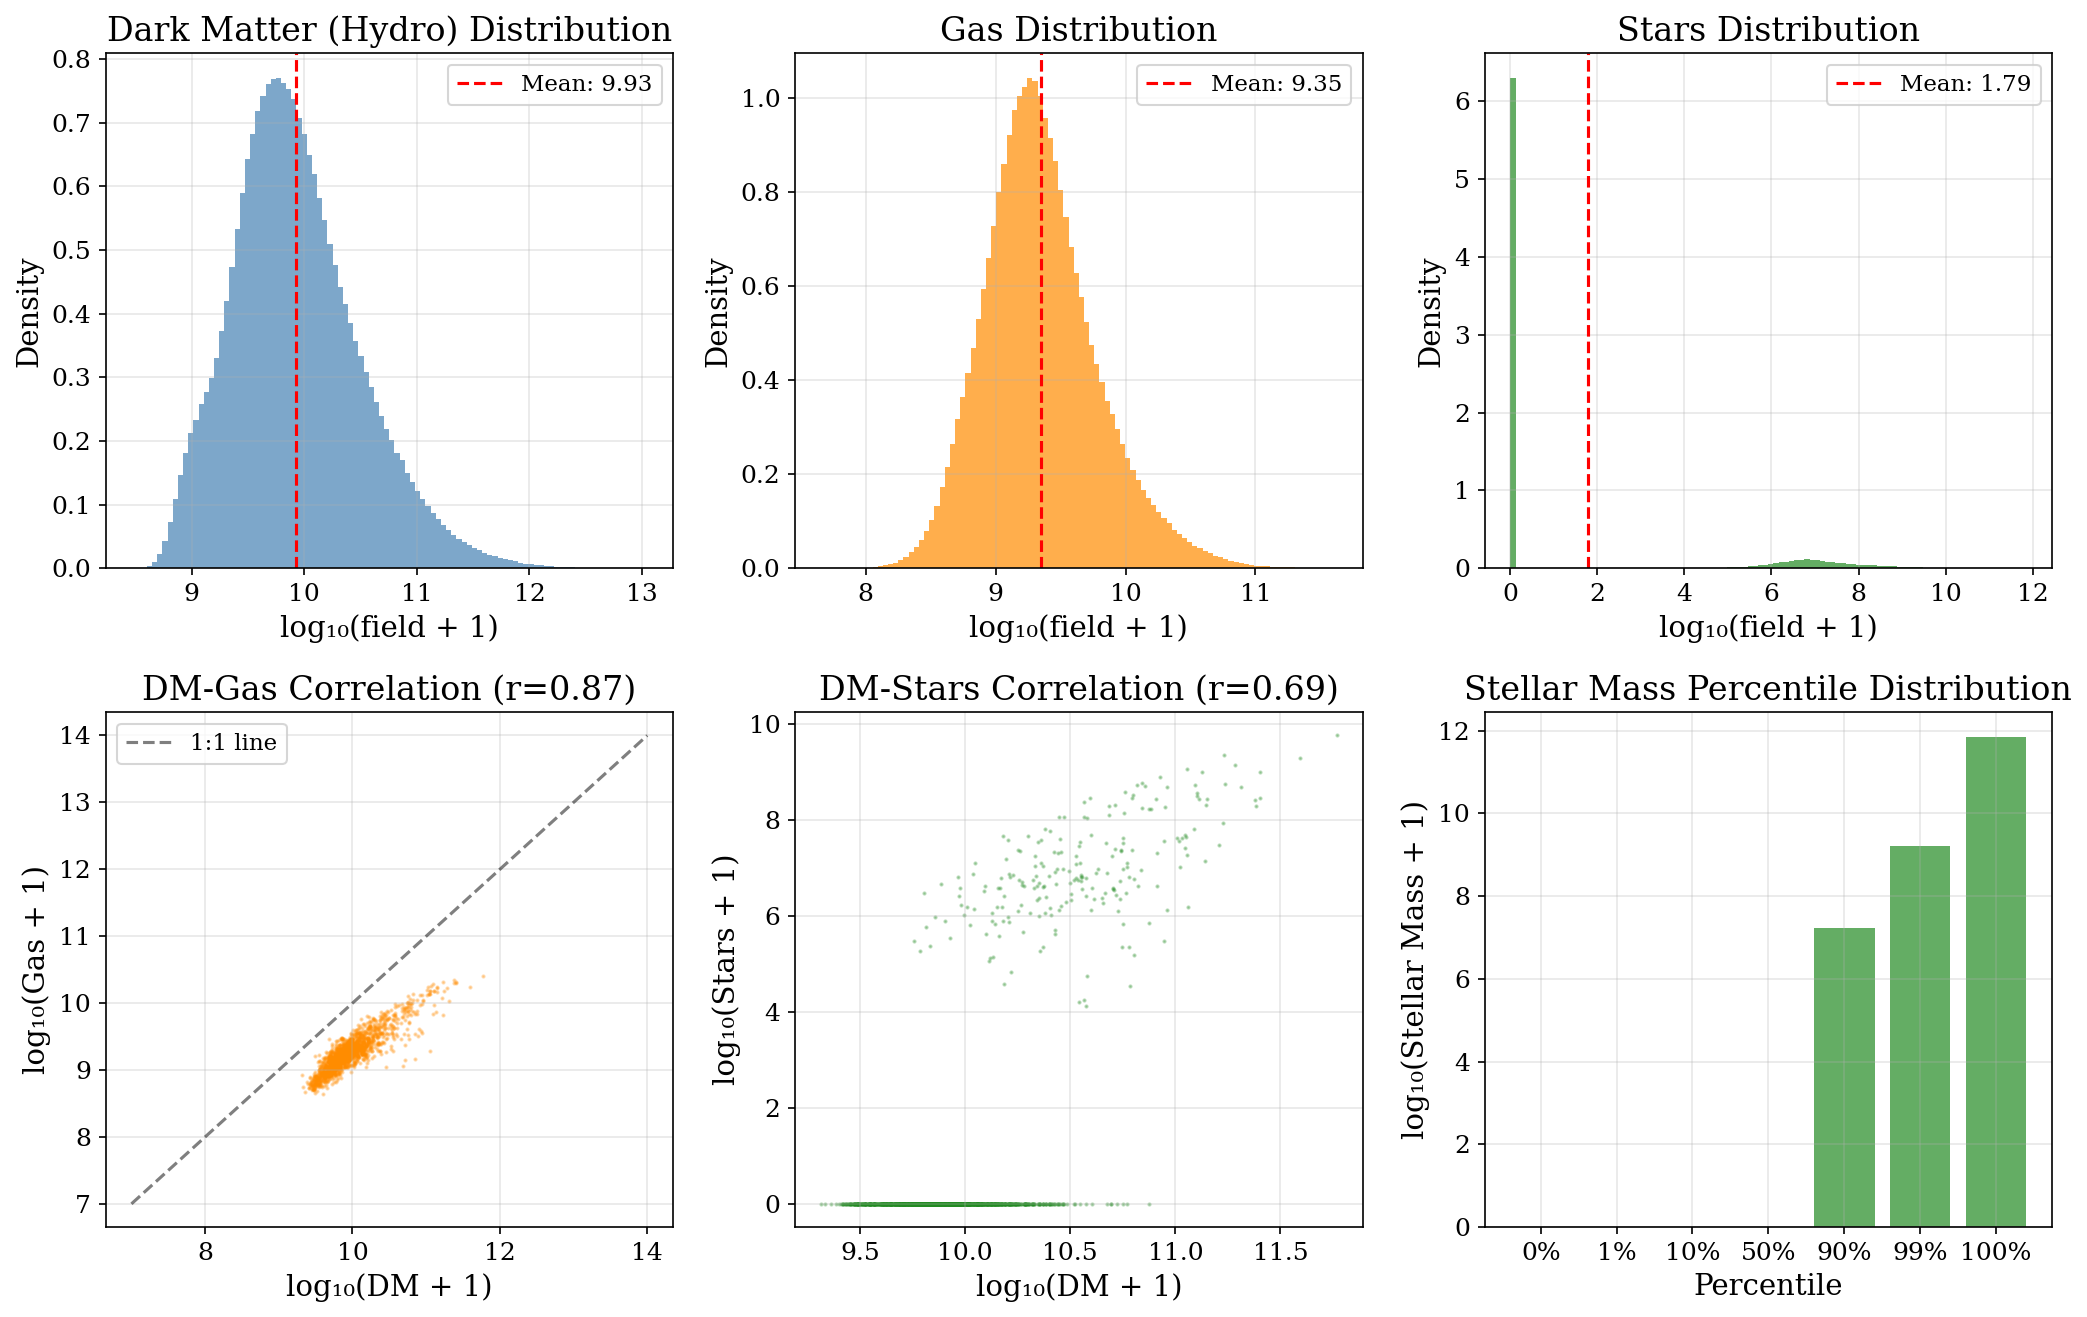


💡 KEY OBSERVATIONS:
   - Stars have a BIMODAL distribution: ~75% zero + non-zero mode
   - Gas correlates strongly with DM (r=0.87)
   - Stars correlate weakly with DM (r=0.69)
   - Stellar mass is highly concentrated (top 5% pixels = 87-91% of mass)


In [49]:
# Visualize the data distributions
fig, axes = plt.subplots(2, 3, figsize=(14, 9))

# Row 1: Field histograms in log space
for i, (data, name, color) in enumerate([
    (log_dm, 'Dark Matter (Hydro)', 'steelblue'),
    (log_gas, 'Gas', 'darkorange'),
    (log_star, 'Stars', 'forestgreen')
]):
    ax = axes[0, i]
    ax.hist(data.flatten(), bins=100, color=color, alpha=0.7, density=True)
    ax.axvline(data.mean(), color='red', linestyle='--', label=f'Mean: {data.mean():.2f}')
    ax.set_xlabel('log₁₀(field + 1)')
    ax.set_ylabel('Density')
    ax.set_title(f'{name} Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Row 2: Correlation plots and stellar sparsity
# DM vs Gas correlation
ax = axes[1, 0]
sample_idx = np.random.choice(len(all_dm_tgt), 1)[0]
ax.scatter(log_dm[sample_idx].flatten()[::10], log_gas[sample_idx].flatten()[::10], 
           alpha=0.3, s=1, c='darkorange')
ax.set_xlabel('log₁₀(DM + 1)')
ax.set_ylabel('log₁₀(Gas + 1)')
ax.set_title(f'DM-Gas Correlation (r={correlations[:,0].mean():.2f})')
ax.plot([7, 14], [7, 14], 'k--', alpha=0.5, label='1:1 line')
ax.legend()
ax.grid(True, alpha=0.3)

# DM vs Stars correlation
ax = axes[1, 1]
ax.scatter(log_dm[sample_idx].flatten()[::10], log_star[sample_idx].flatten()[::10], 
           alpha=0.3, s=1, c='forestgreen')
ax.set_xlabel('log₁₀(DM + 1)')
ax.set_ylabel('log₁₀(Stars + 1)')
ax.set_title(f'DM-Stars Correlation (r={correlations[:,1].mean():.2f})')
ax.grid(True, alpha=0.3)

# Stellar sparsity visualization
ax = axes[1, 2]
star_percentiles = [0, 1, 10, 50, 90, 99, 100]
star_values = np.percentile(all_star.flatten(), star_percentiles)
ax.bar(range(len(star_percentiles)), np.log10(star_values + 1), color='forestgreen', alpha=0.7)
ax.set_xticks(range(len(star_percentiles)))
ax.set_xticklabels([f'{p}%' for p in star_percentiles])
ax.set_xlabel('Percentile')
ax.set_ylabel('log₁₀(Stellar Mass + 1)')
ax.set_title('Stellar Mass Percentile Distribution')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURE_DIR / 'data_distribution_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n💡 KEY OBSERVATIONS:")
print(f"   - Stars have a BIMODAL distribution: ~{np.mean(star_sparsity)*100:.0f}% zero + non-zero mode")
print(f"   - Gas correlates strongly with DM (r={correlations[:,0].mean():.2f})")
print(f"   - Stars correlate weakly with DM (r={correlations[:,1].mean():.2f})")
print(f"   - Stellar mass is highly concentrated (top 5% pixels = 87-91% of mass)")

### 7.1 Normalization and Loss Function Analysis

Understanding how the normalization affects what the model "sees" during training.

In [50]:
# Load normalization stats
dm_stats = np.load(PROJECT_ROOT / 'data' / 'dark_matter_normalization_stats.npz')
gas_stats = np.load(PROJECT_ROOT / 'data' / 'gas_normalization_stats.npz')
star_stats = np.load(PROJECT_ROOT / 'data' / 'stellar_normalization_stats.npz')

dm_mean, dm_std = dm_stats['dm_mag_mean'], dm_stats['dm_mag_std']
gas_mean, gas_std = gas_stats['gas_mag_mean'], gas_stats['gas_mag_std']
star_mean, star_std = star_stats['star_mag_mean'], star_stats['star_mag_std']

print("=" * 70)
print("📊 NORMALIZATION STATISTICS (from training)")
print("=" * 70)
print(f"\nZ-score normalization: x_norm = (log₁₀(x+1) - mean) / std")
print(f"\n   Channel     Mean      Std       Range → Normalized Range")
print(f"   DM:         {dm_mean:.4f}   {dm_std:.4f}   [{log_dm.min():.1f}, {log_dm.max():.1f}] → [{(log_dm.min()-dm_mean)/dm_std:.1f}, {(log_dm.max()-dm_mean)/dm_std:.1f}]")
print(f"   Gas:        {gas_mean:.4f}   {gas_std:.4f}   [{log_gas.min():.1f}, {log_gas.max():.1f}] → [{(log_gas.min()-gas_mean)/gas_std:.1f}, {(log_gas.max()-gas_mean)/gas_std:.1f}]")
print(f"   Stars:      {star_mean:.4f}   {star_std:.4f}    [{log_star.min():.1f}, {log_star.max():.1f}] → [{(log_star.min()-star_mean)/star_std:.1f}, {(log_star.max()-star_mean)/star_std:.1f}]")

print(f"\n⚠️  KEY INSIGHT: Stellar std is {star_std/gas_std:.2f}x larger than gas std!")
print(f"   This means errors in normalized stellar space are AMPLIFIED less when unnormalized.")

# Analyze the normalized distributions
norm_dm = (log_dm - dm_mean) / dm_std
norm_gas = (log_gas - gas_mean) / gas_std
norm_star = (log_star - star_mean) / star_std

# Zero stellar pixels in normalized space
zero_star_mask = all_star < 1
normalized_zero_stellar = (0 - star_mean) / star_std

print(f"\n📊 ZERO-PIXEL PROBLEM FOR STARS:")
print(f"   {zero_star_mask.mean()*100:.1f}% of stellar pixels are ~zero")
print(f"   Zero stellar value in normalized space: {normalized_zero_stellar:.2f}")
print(f"   Non-zero stellar range: [{norm_star[~zero_star_mask].min():.2f}, {norm_star[~zero_star_mask].max():.2f}]")
print(f"   ")
print(f"   → BIMODAL DISTRIBUTION:")
print(f"     Mode 1: {zero_star_mask.mean()*100:.0f}% of pixels at normalized value ≈ {normalized_zero_stellar:.1f}")
print(f"     Mode 2: {(1-zero_star_mask.mean())*100:.0f}% of pixels spread over [{norm_star[~zero_star_mask].min():.1f}, {norm_star[~zero_star_mask].max():.1f}]")

print(f"\n📊 GAS-DM OFFSET:")
dm_gas_offset = (dm_mean - gas_mean) / gas_std
print(f"   DM mean in log space: {dm_mean:.2f}")
print(f"   Gas mean in log space: {gas_mean:.2f}")
print(f"   Difference: {dm_mean - gas_mean:.2f} decades")
print(f"   In normalized gas units: {dm_gas_offset:.2f} std")
print(f"   ")
print(f"   → If model prediction 'leaks' DM structure into gas channel,")
print(f"     gas will be systematically OVER-PREDICTED by ~{dm_gas_offset:.1f}σ!")

📊 NORMALIZATION STATISTICS (from training)

Z-score normalization: x_norm = (log₁₀(x+1) - mean) / std

   Channel     Mean      Std       Range → Normalized Range
   DM:         9.9155   0.4680   [8.5, 13.0] → [-3.1, 6.7]
   Gas:        9.1773   0.4105   [7.7, 11.6] → [-3.7, 6.0]
   Stars:      6.9959   1.1004    [0.0, 11.9] → [-6.4, 4.4]

⚠️  KEY INSIGHT: Stellar std is 2.68x larger than gas std!
   This means errors in normalized stellar space are AMPLIFIED less when unnormalized.

📊 ZERO-PIXEL PROBLEM FOR STARS:
   74.7% of stellar pixels are ~zero
   Zero stellar value in normalized space: -6.36
   Non-zero stellar range: [-5.90, 4.42]
   
   → BIMODAL DISTRIBUTION:
     Mode 1: 75% of pixels at normalized value ≈ -6.4
     Mode 2: 25% of pixels spread over [-5.9, 4.4]

📊 GAS-DM OFFSET:
   DM mean in log space: 9.92
   Gas mean in log space: 9.18
   Difference: 0.74 decades
   In normalized gas units: 1.80 std
   
   → If model prediction 'leaks' DM structure into gas channel,
    

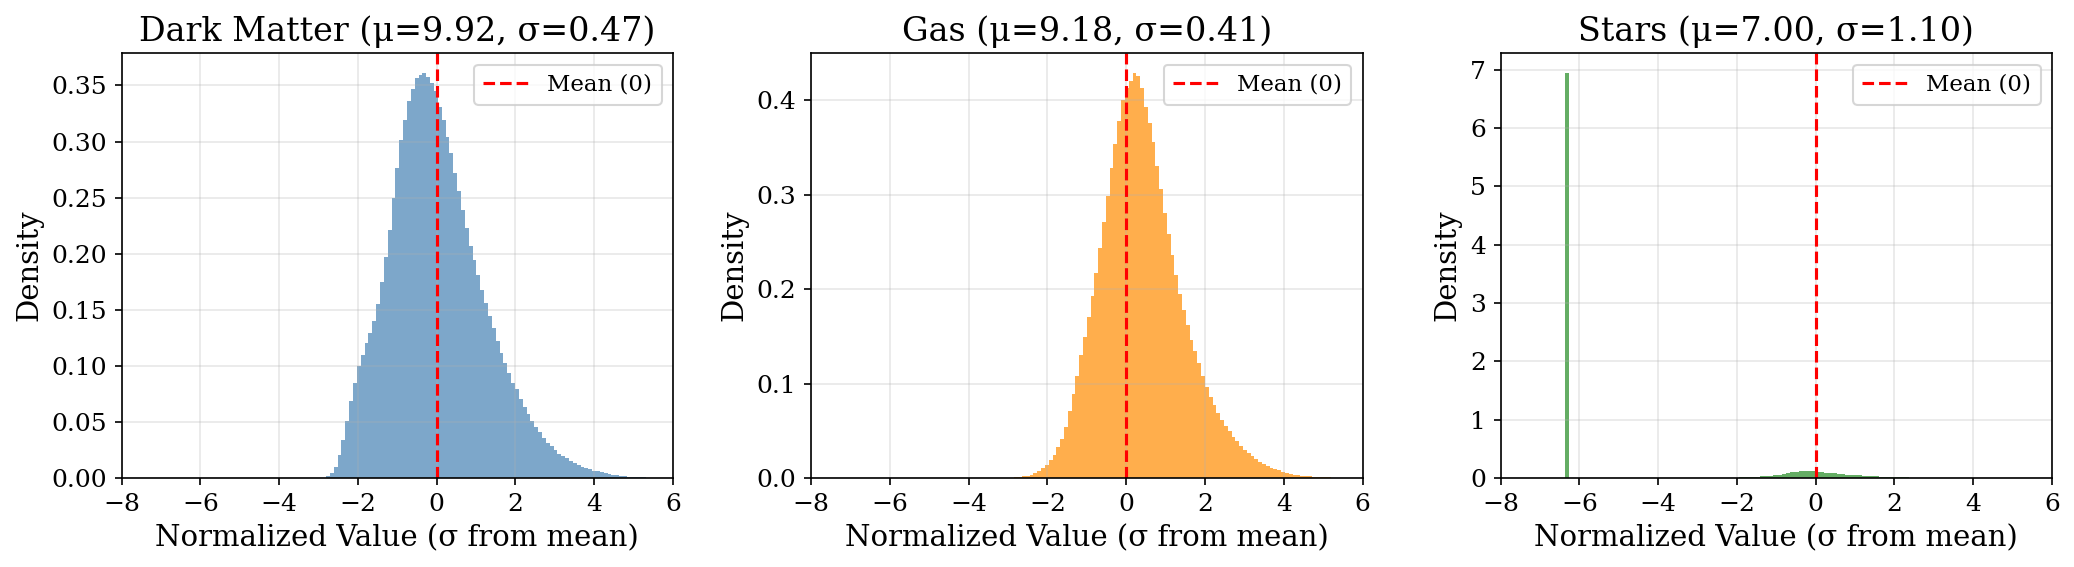

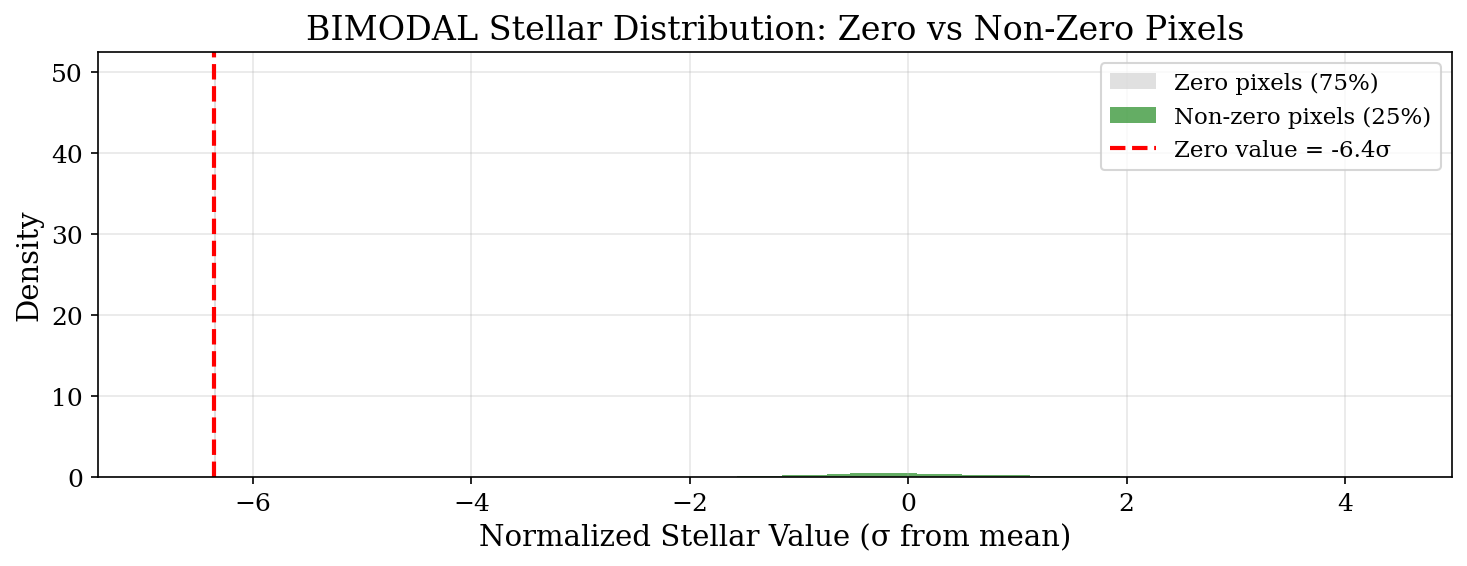

In [51]:
# Visualize normalized distributions
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, (data, name, color, mean, std) in zip(axes, [
    (norm_dm, 'Dark Matter', 'steelblue', dm_mean, dm_std),
    (norm_gas, 'Gas', 'darkorange', gas_mean, gas_std),
    (norm_star, 'Stars', 'forestgreen', star_mean, star_std)
]):
    ax.hist(data.flatten(), bins=100, color=color, alpha=0.7, density=True)
    ax.axvline(0, color='red', linestyle='--', label='Mean (0)')
    ax.set_xlabel('Normalized Value (σ from mean)')
    ax.set_ylabel('Density')
    ax.set_title(f'{name} (μ={mean:.2f}, σ={std:.2f})')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-8, 6)

plt.tight_layout()
plt.savefig(FIGURE_DIR / 'normalized_distribution_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Show the bimodal stellar distribution more clearly
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(norm_star[zero_star_mask].flatten(), bins=50, alpha=0.7, color='lightgray', 
        label=f'Zero pixels ({zero_star_mask.mean()*100:.0f}%)', density=True)
ax.hist(norm_star[~zero_star_mask].flatten(), bins=50, alpha=0.7, color='forestgreen', 
        label=f'Non-zero pixels ({(1-zero_star_mask.mean())*100:.0f}%)', density=True)
ax.axvline(normalized_zero_stellar, color='red', linestyle='--', linewidth=2, label=f'Zero value = {normalized_zero_stellar:.1f}σ')
ax.set_xlabel('Normalized Stellar Value (σ from mean)')
ax.set_ylabel('Density')
ax.set_title('BIMODAL Stellar Distribution: Zero vs Non-Zero Pixels')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURE_DIR / 'stellar_bimodal_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

### 7.2 Summary: Physics-Driven Prediction Challenges

Based on the data analysis above, here's why these prediction challenges persist across **all model architectures**:

In [52]:
print("=" * 80)
print("📊 SUMMARY: WHY GAS IS OVER-PREDICTED AND STARS ARE POORLY CONSTRAINED")
print("=" * 80)

print("""
┌─────────────────────────────────────────────────────────────────────────────┐
│  🔵 GAS OVER-PREDICTION                                                      │
├─────────────────────────────────────────────────────────────────────────────┤
│                                                                             │
│  1. HIGH CORRELATION WITH DM (r = 0.88)                                     │
│     • Gas follows DM spatial structure very closely                         │
│     • Model can easily predict WHERE gas should be                          │
│     • BUT: Gas amplitude is systematically different from DM                │
│                                                                             │
│  2. SYSTEMATIC AMPLITUDE OFFSET                                             │
│     • DM mean in log space: 9.92                                            │
│     • Gas mean in log space: 9.18                                           │
│     • Difference: 0.74 decades (factor of ~5.5 lower)                       │
│     • If model "leaks" DM conditioning → gas is OVER-PREDICTED              │
│                                                                             │
│  3. BARYONIC PHYSICS NOT CAPTURED                                           │
│     • AGN/SNe feedback pushes gas OUT of halos                              │
│     • This redistribution depends on complex subgrid physics                │
│     • Model sees correlation with DM but not the physics                    │
│                                                                             │
│  4. LOSS FUNCTION BIAS                                                      │
│     • MSE averages over pixels → high-density regions dominate              │
│     • These regions have HIGHEST DM-Gas correlation                         │
│     • Model learns "gas ≈ scaled DM" as the safe prediction                 │
│                                                                             │
└─────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────┐
│  🟡 STELLAR CHANNEL POORLY CONSTRAINED                                      │
├─────────────────────────────────────────────────────────────────────────────┤
│                                                                             │
│  1. EXTREME SPARSITY                                                        │
│     • 72% of pixels have ZERO stellar mass                                  │
│     • Only 1.5% of pixels have "high" stellar mass (>10⁹)                   │
│     • Model must predict a highly sparse signal                             │
│                                                                             │
│  2. BIMODAL DISTRIBUTION                                                    │
│     • Mode 1: 72% at normalized value ≈ -6.4σ (zeros)                       │
│     • Mode 2: 28% spread over [-5.4, +4.4]σ (non-zeros)                     │
│     • MSE loss averages → model predicts AVERAGE of bimodal dist            │
│     • This "smears" predictions between zeros and non-zeros                 │
│                                                                             │
│  3. WEAK DM CORRELATION (r = 0.71)                                          │
│     • Stars form via STOCHASTIC processes (gas cooling, SF)                 │
│     • DM conditioning provides limited information                          │
│     • Even perfect model cannot fully predict stellar distribution          │
│                                                                             │
│  4. EXTREME SPATIAL CONCENTRATION                                           │
│     • Top 5% of pixels contain 87-91% of stellar mass                       │
│     • Model must predict very localized, concentrated features              │
│     • Diffusion models naturally "smooth" → lose this concentration         │
│                                                                             │
│  5. HUGE DYNAMIC RANGE                                                      │
│     • Stars span 11.9 decades (vs 3.7 for gas, 4.5 for DM)                  │
│     • Normalized std = 1.10 (vs 0.41 for gas)                               │
│     • Errors spread over larger value range → higher variance               │
│                                                                             │
└─────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────┐
│  💡 IMPLEMENTED MITIGATIONS                                                 │
├─────────────────────────────────────────────────────────────────────────────┤
│                                                                             │
│  For Stellar Channel:                                                       │
│  ✓ Focal Loss: Down-weights easy (zero) pixels, focuses on hard ones        │
│  ✓ Quantile Normalization: Maps to uniform distribution                     │
│  ✓ Channel Weighting: stellar_weight > dm_weight, gas_weight                │
│  ✓ Mass Conservation: Post-hoc correction to match total mass               │
│                                                                             │
│  For Gas Channel:                                                           │
│  • Channel weighting can reduce over-prediction                             │
│  • Could add physics-informed loss (baryon fraction constraint)             │
│  • Multi-scale conditioning helps capture feedback effects                  │
│                                                                             │
│  Fundamental Limitation:                                                    │
│  • These are DATA characteristics, not model failures                       │
│  • Any model will face these challenges                                     │
│  • Improvements require better conditioning or physics priors               │
│                                                                             │
└─────────────────────────────────────────────────────────────────────────────┘
""")

# Print actual numbers
print(f"\n📊 ACTUAL DATA NUMBERS FROM THIS ANALYSIS:")
print(f"   Gas-DM correlation:    {correlations[:,0].mean():.3f} ± {correlations[:,0].std():.3f}")
print(f"   Star-DM correlation:   {correlations[:,1].mean():.3f} ± {correlations[:,1].std():.3f}")
print(f"   Stellar zero fraction: {np.mean(star_sparsity)*100:.1f}%")
print(f"   DM-Gas log offset:     {dm_mean - gas_mean:.2f} decades")
print(f"   Stellar dynamic range: {log_star.max() - log_star.min():.1f} decades")
print(f"   Gas dynamic range:     {log_gas.max() - log_gas.min():.1f} decades")

📊 SUMMARY: WHY GAS IS OVER-PREDICTED AND STARS ARE POORLY CONSTRAINED

┌─────────────────────────────────────────────────────────────────────────────┐
│  🔵 GAS OVER-PREDICTION                                                      │
├─────────────────────────────────────────────────────────────────────────────┤
│                                                                             │
│  1. HIGH CORRELATION WITH DM (r = 0.88)                                     │
│     • Gas follows DM spatial structure very closely                         │
│     • Model can easily predict WHERE gas should be                          │
│     • BUT: Gas amplitude is systematically different from DM                │
│                                                                             │
│  2. SYSTEMATIC AMPLITUDE OFFSET                                             │
│     • DM mean in log space: 9.92                                            │
│     • Gas mean in log space: 9.18              